# Lane Line Findings

Note: All the process to detect lane lines in test video is executed in `process_image` function in `Defining image processing method` section. 

## Camera Calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import glob
%matplotlib inline

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

def collect_callibration_points():
    objpoints = []
    imgpoints = []
   
    images = glob.glob('./camera_cal/calibration*.jpg')
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
    
    for fname in images:
        img = mpimg.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        
    return imgpoints, objpoints

def compare_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    f.tight_layout()
    ax1.imshow(image1,cmap=cm.gray)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2,cmap=cm.gray)
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
imgpoints, objpoints = collect_callibration_points()
img = mpimg.imread('./camera_cal/calibration3.jpg')
undistorted, mtx, dist_coefficients = cal_undistort(img, objpoints, imgpoints)
#compare_images(img, undistorted, "Original Image", "Undistorted Image")

image_path = './images/path_1.jpg'
image = mpimg.imread(image_path)
image, mtx, dist_coefficients = cal_undistort(image, objpoints, imgpoints)

## Gradient Thresholds

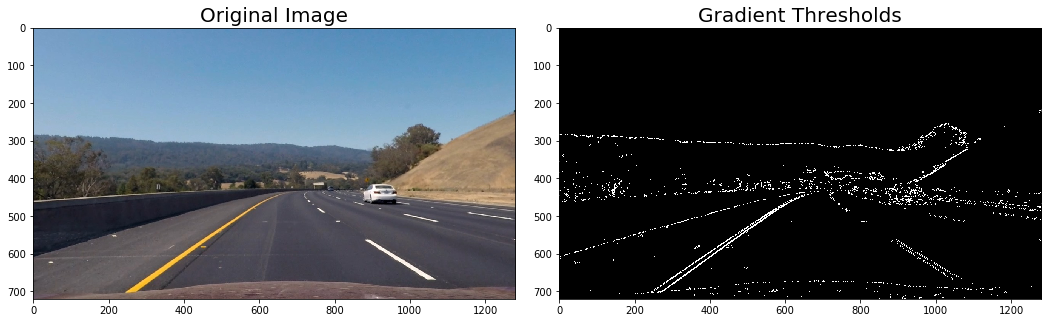

In [3]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    isX = True if orient == 'x' else False
    sobel = cv2.Sobel(gray, cv2.CV_64F, isX, not isX)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
   
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return dir_binary

def apply_thresholds(image, ksize=3):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

combined = apply_thresholds(image)
compare_images(image, combined, "Original Image", "Gradient Thresholds")

## Color Threshold

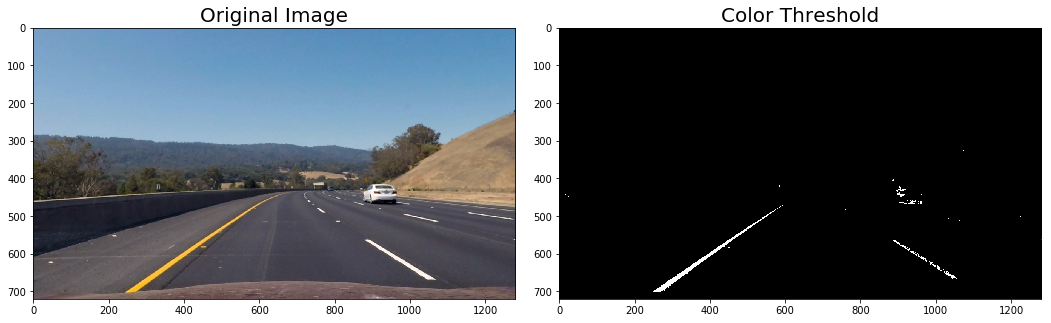

In [4]:
def apply_color_threshold(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    return s_binary
    
    
s_binary = apply_color_threshold(image)
compare_images(image, s_binary, "Original Image", "Color Threshold")

## Combine Color and Gradient

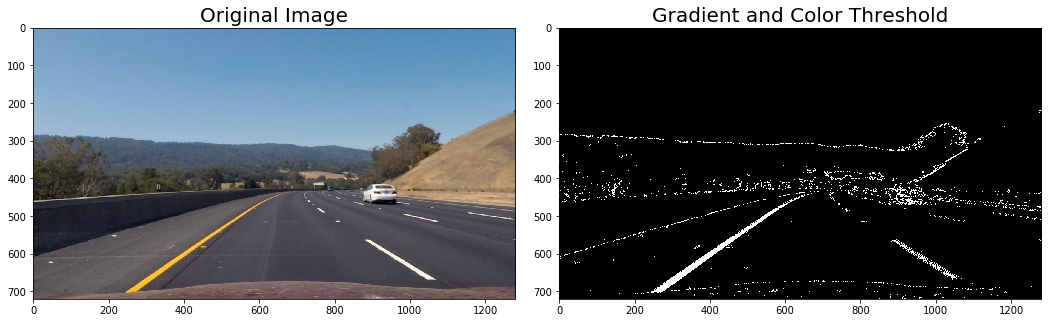

In [5]:
def combine_threshold(s_binary, combined):
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary


combined_binary = combine_threshold(s_binary, combined)
compare_images(image, combined_binary, "Original Image", "Gradient and Color Threshold")

## Perspective Transform

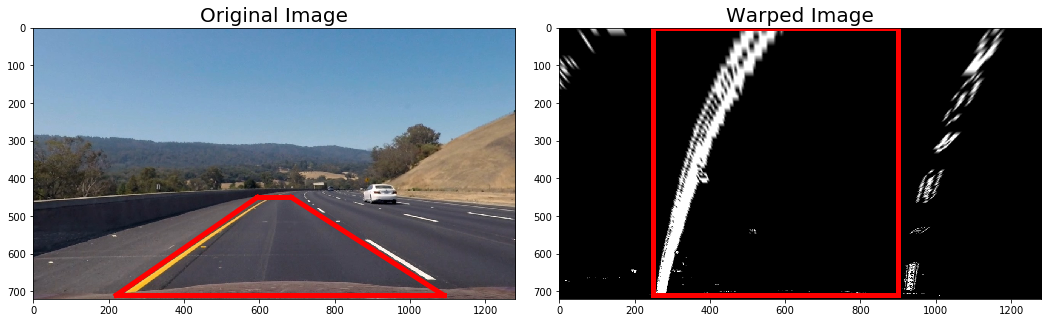

In [6]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[685, 450], 
          [1090, 710], 
          [220, 710], 
          [595, 450]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 710], 
          [250, 710], 
          [250, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
   
    return binary_warped, Minv

def compare_plotted_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    f.tight_layout()
    ax1.imshow(image1,cmap=cm.gray)
    ax1.plot([685, 1090], [450, 710], color='r', linewidth="5")
    ax1.plot([1090, 220], [710, 710], color='r', linewidth="5")
    ax1.plot([220, 595], [710, 450], color='r', linewidth="5")
    ax1.plot([595, 685], [450, 450], color='r', linewidth="5")
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2,cmap=cm.gray)
    ax2.plot([900, 900], [0, 710], color='r', linewidth="5")
    ax2.plot([900, 250], [710, 710], color='r', linewidth="5")
    ax2.plot([250, 250], [710, 0], color='r', linewidth="5")
    ax2.plot([250, 900], [0, 0], color='r', linewidth="5")
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
warped, Minv = warp(combined_binary)
compare_plotted_images(image, warped, "Original Image", "Warped Image")

# Finding the Lines

## Histogram

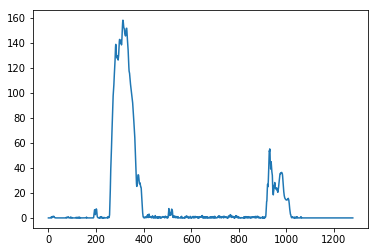

In [7]:
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    return histogram
    
    
binary_warped, Minv = warp(combined_binary)
histogram = get_histogram(binary_warped)
plt.plot(histogram)

## Sliding Window

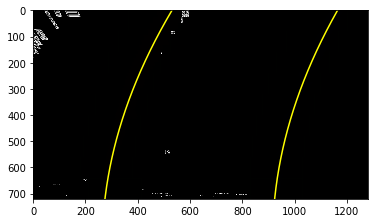

In [8]:
def slide_window(binary_warped, histogram):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return ploty, left_fit, right_fit

ploty, left_fit, right_fit = slide_window(binary_warped, histogram)

## Skipping Slinding Window

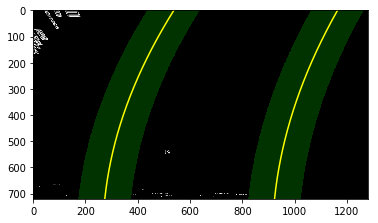

In [9]:
def skip_sliding_window(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  
    
    ################################ 
    ## Visualization
    ################################ 
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    ret = {}
    ret['leftx'] = leftx
    ret['rightx'] = rightx
    ret['left_fitx'] = left_fitx
    ret['right_fitx'] = right_fitx
    ret['ploty'] = ploty
    
    return ret

draw_info = skip_sliding_window(binary_warped, left_fit, right_fit)

## Measuring Curvature

In [10]:
def measure_curvature(ploty, lines_info):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 

    leftx = lines_info['left_fitx']
    rightx = lines_info['right_fitx']

    leftx = leftx[::-1]  
    rightx = rightx[::-1]  

    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad
    
left_curverad, right_curverad = measure_curvature(ploty, draw_info)

456.896713858 m 516.753702418 m


## Drawing

(<matplotlib.image.AxesImage at 0x122ce0400>,
 (-0.5, 1279.5, 719.5, -0.5))

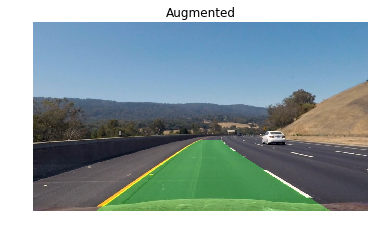

In [11]:
def draw_lane_lines(original_image, warped_image, Minv, draw_info):
    leftx = draw_info['leftx']
    rightx = draw_info['rightx']
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']
    
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    return result


result = draw_lane_lines(image, binary_warped, Minv, draw_info)
plt.imshow(result),plt.title('Augmented'),plt.axis("off")

## Defining image processing method

In [12]:
global used_warped
global used_ret

def process_image(image):
    global used_warped
    global used_ret
    
    #Undistort image
    image, mtx, dist_coefficients = cal_undistort(image, objpoints, imgpoints)
    
    # Gradient thresholding
    gradient_combined = apply_thresholds(image)
   
    # Color thresholding
    s_binary = apply_color_threshold(image)
    
    # Combine Gradient and Color thresholding
    combined_binary = combine_threshold(s_binary, gradient_combined)
   
    # Transforming Perspective
    binary_warped, Minv = warp(combined_binary)
    
  
    # Getting Histogram
    histogram = get_histogram(binary_warped)
  
    # Sliding Window to detect lane lines
    ploty, left_fit, right_fit = slide_window(binary_warped, histogram)
    
    # Skipping Sliding Window
    ret = skip_sliding_window(binary_warped, left_fit, right_fit)
    
    
    # Measuring Curvature
    left_curverad, right_curverad = measure_curvature(ploty, ret)
    
     # Sanity check: whether the lines are roughly parallel and have similar curvature
    slope_left = ret['left_fitx'][0] - ret['left_fitx'][-1]
    slope_right = ret['right_fitx'][0] - ret['right_fitx'][-1]
    slope_diff = abs(slope_left - slope_right)
    slope_threshold = 150
    curve_diff = abs(left_curverad - right_curverad)
    curve_threshold = 10000
    
    if (slope_diff > slope_threshold or curve_diff > curve_threshold):
        binary_warped = used_warped
        ret = used_ret
   
    # Visualizing Lane Lines Info
    result = draw_lane_lines(image, binary_warped, Minv, ret)
    
    # Annotating curvature 
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    curvature_text = 'The radius of curvature = ' + str(round(left_curverad, 3)) + 'm'
    cv2.putText(result, curvature_text, (30, 60), fontType, 1.5, (255, 255, 255), 3)
   
    # Annotating deviation
    deviation_pixels = image.shape[1]/2 - abs(ret['right_fitx'][-1] - ret['left_fitx'][-1])
    xm_per_pix = 3.7/700 
    deviation = deviation_pixels * xm_per_pix
    direction = "left" if deviation < 0 else "right"
    deviation_text = 'Vehicle is ' + str(round(abs(deviation), 3)) + 'm ' + direction + ' of center'
    cv2.putText(result, deviation_text, (30, 110), fontType, 1.5, (255, 255, 255), 3)
    
    used_warped = binary_warped
    used_ret = ret
    return result 

#result_image = process_image(image)
#plt.imshow(result_image)

## Applying to Video 

In [13]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

373.06845538 m 658.715212662 m
[MoviePy] >>>> Building video videos/result_1.mp4
[MoviePy] Writing video videos/result_1.mp4


  0%|          | 1/1261 [00:00<10:02,  2.09it/s]

373.06845538 m 658.715212662 m


  0%|          | 2/1261 [00:00<10:04,  2.08it/s]

387.008845952 m 546.553791349 m


  0%|          | 3/1261 [00:01<09:56,  2.11it/s]

388.197985204 m 618.068241349 m


  0%|          | 4/1261 [00:01<10:02,  2.09it/s]

377.507355847 m 514.374975832 m


  0%|          | 5/1261 [00:02<10:00,  2.09it/s]

407.428063255 m 440.29903724 m


  0%|          | 6/1261 [00:02<10:02,  2.08it/s]

399.906952626 m 387.004225876 m


  1%|          | 7/1261 [00:03<10:03,  2.08it/s]

407.845074284 m 381.609908269 m


  1%|          | 8/1261 [00:03<10:02,  2.08it/s]

435.507512746 m 355.930659797 m


  1%|          | 9/1261 [00:04<10:01,  2.08it/s]

438.677321466 m 482.55000948 m


  1%|          | 10/1261 [00:04<09:59,  2.09it/s]

417.845687432 m 570.697849906 m


  1%|          | 11/1261 [00:05<09:58,  2.09it/s]

419.625923321 m 848.175317354 m


  1%|          | 12/1261 [00:05<09:57,  2.09it/s]

447.728327469 m 717.326766034 m


  1%|          | 13/1261 [00:06<09:56,  2.09it/s]

434.872189917 m 772.147179646 m


  1%|          | 14/1261 [00:06<09:55,  2.10it/s]

446.616242973 m 530.843906503 m


  1%|          | 15/1261 [00:07<09:54,  2.10it/s]

451.31197604 m 442.652697359 m


  1%|▏         | 16/1261 [00:07<09:53,  2.10it/s]

424.226247595 m 367.997678595 m


  1%|▏         | 17/1261 [00:08<09:53,  2.10it/s]

415.349955926 m 335.38952305 m


  1%|▏         | 18/1261 [00:08<09:52,  2.10it/s]

488.963722514 m 354.16257937 m


  2%|▏         | 19/1261 [00:09<09:51,  2.10it/s]

490.630861581 m 334.129228515 m


  2%|▏         | 20/1261 [00:09<09:51,  2.10it/s]

500.023690506 m 334.587148329 m


  2%|▏         | 21/1261 [00:09<09:50,  2.10it/s]

505.004493951 m 308.11031444 m


  2%|▏         | 22/1261 [00:10<09:49,  2.10it/s]

499.017747651 m 317.01641508 m


  2%|▏         | 23/1261 [00:10<09:49,  2.10it/s]

518.993076167 m 371.953469909 m


  2%|▏         | 24/1261 [00:11<09:49,  2.10it/s]

463.744013623 m 472.017438718 m


  2%|▏         | 25/1261 [00:11<09:48,  2.10it/s]

429.619696069 m 702.131364745 m


  2%|▏         | 26/1261 [00:12<09:48,  2.10it/s]

443.551612833 m 854.29417474 m


  2%|▏         | 27/1261 [00:12<09:48,  2.10it/s]

424.839790758 m 653.800676099 m


  2%|▏         | 28/1261 [00:13<09:48,  2.09it/s]

437.967414569 m 609.652336008 m


  2%|▏         | 29/1261 [00:13<09:49,  2.09it/s]

431.033843651 m 475.924132116 m


  2%|▏         | 30/1261 [00:14<09:50,  2.09it/s]

374.602458617 m 495.414569608 m


  2%|▏         | 31/1261 [00:14<09:50,  2.08it/s]

356.911137484 m 296.902782246 m


  3%|▎         | 32/1261 [00:15<09:50,  2.08it/s]

327.007736692 m 284.234170258 m


  3%|▎         | 33/1261 [00:15<09:50,  2.08it/s]

323.324169307 m 265.991192337 m


  3%|▎         | 34/1261 [00:16<09:49,  2.08it/s]

330.037692708 m 336.210166322 m


  3%|▎         | 35/1261 [00:16<09:49,  2.08it/s]

317.948658526 m 396.790075221 m


  3%|▎         | 36/1261 [00:17<09:49,  2.08it/s]

292.751784957 m 411.35893044 m


  3%|▎         | 37/1261 [00:17<09:48,  2.08it/s]

287.909216281 m 381.837774869 m


  3%|▎         | 38/1261 [00:18<09:48,  2.08it/s]

290.280341827 m 281.932801435 m


  3%|▎         | 39/1261 [00:18<09:47,  2.08it/s]

279.024933929 m 268.408175723 m


  3%|▎         | 40/1261 [00:19<09:46,  2.08it/s]

285.388622555 m 314.442675574 m


  3%|▎         | 41/1261 [00:19<09:46,  2.08it/s]

299.395951769 m 268.470363057 m


  3%|▎         | 42/1261 [00:20<09:45,  2.08it/s]

321.939011116 m 277.766112299 m


  3%|▎         | 43/1261 [00:20<09:45,  2.08it/s]

335.973850892 m 276.176573908 m


  3%|▎         | 44/1261 [00:21<09:45,  2.08it/s]

357.896917094 m 273.601353995 m


  4%|▎         | 45/1261 [00:21<09:44,  2.08it/s]

352.141653063 m 294.82801589 m


  4%|▎         | 46/1261 [00:22<09:44,  2.08it/s]

386.6315585 m 294.415005134 m


  4%|▎         | 47/1261 [00:22<09:43,  2.08it/s]

386.715437166 m 348.005200934 m


  4%|▍         | 48/1261 [00:23<09:43,  2.08it/s]

397.975988157 m 423.502352286 m


  4%|▍         | 49/1261 [00:23<09:42,  2.08it/s]

440.201705688 m 437.728641233 m


  4%|▍         | 50/1261 [00:24<09:42,  2.08it/s]

437.112245408 m 371.742314899 m


  4%|▍         | 51/1261 [00:24<09:42,  2.08it/s]

455.454322403 m 489.968289307 m


  4%|▍         | 52/1261 [00:25<09:42,  2.08it/s]

441.364909779 m 445.554124868 m


  4%|▍         | 53/1261 [00:25<09:42,  2.07it/s]

456.571018392 m 412.707291216 m


  4%|▍         | 54/1261 [00:26<09:42,  2.07it/s]

476.379650292 m 394.875295257 m


  4%|▍         | 55/1261 [00:26<09:42,  2.07it/s]

459.96913827 m 347.357099914 m


  4%|▍         | 56/1261 [00:27<09:42,  2.07it/s]

498.071033145 m 346.471057715 m


  5%|▍         | 57/1261 [00:27<09:42,  2.07it/s]

479.739514141 m 356.034832809 m


  5%|▍         | 58/1261 [00:28<09:42,  2.07it/s]

464.119428495 m 404.671257638 m


  5%|▍         | 59/1261 [00:28<09:42,  2.07it/s]

402.584159219 m 574.881246101 m


  5%|▍         | 60/1261 [00:29<09:41,  2.06it/s]

405.161719252 m 326.086123909 m


  5%|▍         | 61/1261 [00:29<09:41,  2.06it/s]

443.264793015 m 344.380237373 m


  5%|▍         | 62/1261 [00:30<09:41,  2.06it/s]

419.790001184 m 312.557711113 m


  5%|▍         | 63/1261 [00:30<09:41,  2.06it/s]

418.433981619 m 313.939709323 m


  5%|▌         | 64/1261 [00:31<09:41,  2.06it/s]

408.212861014 m 295.140403898 m


  5%|▌         | 65/1261 [00:31<09:41,  2.06it/s]

421.680418801 m 304.68353807 m


  5%|▌         | 66/1261 [00:32<09:41,  2.06it/s]

390.274314493 m 356.176553919 m


  5%|▌         | 67/1261 [00:32<09:42,  2.05it/s]

414.190466858 m 380.35055792 m


  5%|▌         | 68/1261 [00:33<09:45,  2.04it/s]

438.684057404 m 430.34524758 m


  5%|▌         | 69/1261 [00:33<09:46,  2.03it/s]

409.447702596 m 380.994624663 m


  6%|▌         | 70/1261 [00:34<09:47,  2.03it/s]

466.539479885 m 398.127454795 m


  6%|▌         | 71/1261 [00:35<09:46,  2.03it/s]

458.687664084 m 455.59649153 m


  6%|▌         | 72/1261 [00:35<09:46,  2.03it/s]

445.651346029 m 505.932895383 m


  6%|▌         | 73/1261 [00:36<09:47,  2.02it/s]

460.807767898 m 390.986573897 m


  6%|▌         | 74/1261 [00:36<09:46,  2.02it/s]

475.70357583 m 358.545573976 m


  6%|▌         | 75/1261 [00:37<09:46,  2.02it/s]

512.450454904 m 325.909574746 m


  6%|▌         | 76/1261 [00:37<09:46,  2.02it/s]

485.327097168 m 354.533957153 m


  6%|▌         | 77/1261 [00:38<09:46,  2.02it/s]

528.382402463 m 375.813579723 m


  6%|▌         | 78/1261 [00:38<09:47,  2.02it/s]

582.45058827 m 433.161576794 m


  6%|▋         | 79/1261 [00:39<09:47,  2.01it/s]

571.277820718 m 400.852285366 m


  6%|▋         | 80/1261 [00:39<09:46,  2.01it/s]

555.321564869 m 370.917399872 m


  6%|▋         | 81/1261 [00:40<09:46,  2.01it/s]

527.936062324 m 339.980907886 m


  7%|▋         | 82/1261 [00:40<09:46,  2.01it/s]

536.810305384 m 340.559034059 m


  7%|▋         | 83/1261 [00:41<09:46,  2.01it/s]

516.891860731 m 311.942035378 m


  7%|▋         | 84/1261 [00:41<09:46,  2.01it/s]

528.110147046 m 333.702055497 m


  7%|▋         | 85/1261 [00:42<09:46,  2.01it/s]

495.522735027 m 320.950816286 m


  7%|▋         | 86/1261 [00:42<09:45,  2.01it/s]

426.794518486 m 432.165428952 m


  7%|▋         | 87/1261 [00:43<09:45,  2.01it/s]

396.633431299 m 466.483797652 m


  7%|▋         | 88/1261 [00:43<09:44,  2.01it/s]

368.027193216 m 441.344752642 m


  7%|▋         | 89/1261 [00:44<09:44,  2.01it/s]

369.510606916 m 420.049714435 m


  7%|▋         | 90/1261 [00:44<09:44,  2.00it/s]

334.18796029 m 306.896571207 m


  7%|▋         | 91/1261 [00:45<09:43,  2.00it/s]

354.216542638 m 363.001591973 m


  7%|▋         | 92/1261 [00:45<09:43,  2.00it/s]

370.20831086 m 350.573356013 m


  7%|▋         | 93/1261 [00:46<09:43,  2.00it/s]

391.138498337 m 355.01087295 m


  7%|▋         | 94/1261 [00:47<09:43,  2.00it/s]

372.945879757 m 400.493005036 m


  8%|▊         | 95/1261 [00:47<09:43,  2.00it/s]

392.102825072 m 382.345137183 m


  8%|▊         | 96/1261 [00:48<09:44,  1.99it/s]

348.647042351 m 317.752271852 m


  8%|▊         | 97/1261 [00:48<09:44,  1.99it/s]

345.443771465 m 433.635351624 m


  8%|▊         | 98/1261 [00:49<09:44,  1.99it/s]

358.739248865 m 383.101681066 m


  8%|▊         | 99/1261 [00:49<09:44,  1.99it/s]

342.313017027 m 367.307575985 m


  8%|▊         | 100/1261 [00:50<09:43,  1.99it/s]

344.392868182 m 438.623646162 m


  8%|▊         | 101/1261 [00:50<09:43,  1.99it/s]

344.496919869 m 365.421063614 m


  8%|▊         | 102/1261 [00:51<09:43,  1.99it/s]

345.098482172 m 413.710539804 m


  8%|▊         | 103/1261 [00:51<09:43,  1.98it/s]

340.995834097 m 290.483294911 m


  8%|▊         | 104/1261 [00:52<09:43,  1.98it/s]

343.591938523 m 291.566486505 m


  8%|▊         | 105/1261 [00:52<09:43,  1.98it/s]

361.311703267 m 324.84146028 m


  8%|▊         | 106/1261 [00:53<09:42,  1.98it/s]

369.160160709 m 298.005410962 m


  8%|▊         | 107/1261 [00:53<09:42,  1.98it/s]

363.187173552 m 286.485056996 m


  9%|▊         | 108/1261 [00:54<09:41,  1.98it/s]

345.192375629 m 271.046211404 m


  9%|▊         | 109/1261 [00:55<09:41,  1.98it/s]

370.4408392 m 262.039394598 m


  9%|▊         | 110/1261 [00:55<09:41,  1.98it/s]

348.450664589 m 340.524906663 m


  9%|▉         | 111/1261 [00:56<09:41,  1.98it/s]

329.236083621 m 487.87829746 m


  9%|▉         | 112/1261 [00:56<09:41,  1.98it/s]

363.77328542 m 432.327404691 m


  9%|▉         | 113/1261 [00:57<09:40,  1.98it/s]

331.383539763 m 340.439410273 m


  9%|▉         | 114/1261 [00:57<09:40,  1.98it/s]

323.104307663 m 360.991309637 m


  9%|▉         | 115/1261 [00:58<09:39,  1.98it/s]

307.392169717 m 300.762157396 m


  9%|▉         | 116/1261 [00:58<09:39,  1.98it/s]

307.641289345 m 281.765654882 m


  9%|▉         | 117/1261 [00:59<09:38,  1.98it/s]

326.159215129 m 289.953514119 m


  9%|▉         | 118/1261 [00:59<09:38,  1.98it/s]

327.248537835 m 269.727295914 m


  9%|▉         | 119/1261 [01:00<09:37,  1.98it/s]

334.172460479 m 295.797855545 m


 10%|▉         | 120/1261 [01:00<09:37,  1.98it/s]

329.886445711 m 335.88082542 m


 10%|▉         | 121/1261 [01:01<09:36,  1.98it/s]

330.458117351 m 370.127611485 m


 10%|▉         | 122/1261 [01:01<09:36,  1.97it/s]

338.933270844 m 421.15162301 m


 10%|▉         | 123/1261 [01:02<09:36,  1.97it/s]

316.278506799 m 371.26054462 m


 10%|▉         | 124/1261 [01:02<09:35,  1.97it/s]

314.947544523 m 289.779764788 m


 10%|▉         | 125/1261 [01:03<09:35,  1.97it/s]

313.272444624 m 285.199894095 m


 10%|▉         | 126/1261 [01:03<09:35,  1.97it/s]

339.49157376 m 321.600753426 m


 10%|█         | 127/1261 [01:04<09:34,  1.97it/s]

330.056416299 m 299.07788192 m


 10%|█         | 128/1261 [01:04<09:34,  1.97it/s]

338.606164802 m 275.296498413 m


 10%|█         | 129/1261 [01:05<09:33,  1.97it/s]

338.023456616 m 322.184785964 m


 10%|█         | 130/1261 [01:05<09:33,  1.97it/s]

327.770420074 m 338.719145385 m


 10%|█         | 131/1261 [01:06<09:32,  1.97it/s]

376.606855011 m 368.347980349 m


 10%|█         | 132/1261 [01:06<09:32,  1.97it/s]

399.005666114 m 369.459323253 m


 11%|█         | 133/1261 [01:07<09:32,  1.97it/s]

358.493951746 m 398.254558494 m


 11%|█         | 134/1261 [01:07<09:31,  1.97it/s]

358.205011214 m 426.529350553 m


 11%|█         | 135/1261 [01:08<09:31,  1.97it/s]

388.006345958 m 480.419797426 m


 11%|█         | 136/1261 [01:08<09:30,  1.97it/s]

383.122075604 m 459.202512858 m


 11%|█         | 137/1261 [01:09<09:30,  1.97it/s]

381.572353469 m 501.812708195 m


 11%|█         | 138/1261 [01:10<09:29,  1.97it/s]

411.466708821 m 546.782569562 m


 11%|█         | 139/1261 [01:10<09:29,  1.97it/s]

446.808616194 m 450.798986539 m


 11%|█         | 140/1261 [01:11<09:28,  1.97it/s]

461.283360556 m 574.587228048 m


 11%|█         | 141/1261 [01:11<09:28,  1.97it/s]

510.909017237 m 430.159627647 m


 11%|█▏        | 142/1261 [01:12<09:27,  1.97it/s]

528.881771102 m 417.147195939 m


 11%|█▏        | 143/1261 [01:12<09:27,  1.97it/s]

470.585283788 m 348.374112314 m


 11%|█▏        | 144/1261 [01:13<09:26,  1.97it/s]

453.523821567 m 368.697028016 m


 11%|█▏        | 145/1261 [01:13<09:26,  1.97it/s]

455.5280505 m 362.308019873 m


 12%|█▏        | 146/1261 [01:14<09:25,  1.97it/s]

421.1842105 m 509.460840973 m


 12%|█▏        | 147/1261 [01:14<09:25,  1.97it/s]

414.590408276 m 563.843963189 m


 12%|█▏        | 148/1261 [01:15<09:24,  1.97it/s]

390.890477129 m 368.194154947 m


 12%|█▏        | 149/1261 [01:15<09:24,  1.97it/s]

402.79478706 m 369.477792378 m


 12%|█▏        | 150/1261 [01:16<09:23,  1.97it/s]

394.105762704 m 374.54885042 m


 12%|█▏        | 151/1261 [01:16<09:23,  1.97it/s]

408.804705929 m 525.588884963 m


 12%|█▏        | 152/1261 [01:17<09:22,  1.97it/s]

419.834404947 m 376.235008356 m


 12%|█▏        | 153/1261 [01:17<09:22,  1.97it/s]

405.497725797 m 329.380873581 m


 12%|█▏        | 154/1261 [01:18<09:21,  1.97it/s]

396.86136379 m 375.155291222 m


 12%|█▏        | 155/1261 [01:18<09:21,  1.97it/s]

421.981614234 m 327.926274045 m


 12%|█▏        | 156/1261 [01:19<09:20,  1.97it/s]

391.017775881 m 340.046457744 m


 12%|█▏        | 157/1261 [01:19<09:20,  1.97it/s]

398.881447906 m 369.31464346 m


 13%|█▎        | 158/1261 [01:20<09:19,  1.97it/s]

368.953816217 m 463.816751153 m


 13%|█▎        | 159/1261 [01:20<09:19,  1.97it/s]

392.685918855 m 394.644966007 m


 13%|█▎        | 160/1261 [01:21<09:18,  1.97it/s]

371.126540382 m 361.233451218 m


 13%|█▎        | 161/1261 [01:21<09:18,  1.97it/s]

388.30372573 m 481.752786279 m


 13%|█▎        | 162/1261 [01:22<09:17,  1.97it/s]

401.053307298 m 399.480720145 m


 13%|█▎        | 163/1261 [01:22<09:17,  1.97it/s]

405.657077932 m 397.24348296 m


 13%|█▎        | 164/1261 [01:23<09:16,  1.97it/s]

416.11494661 m 341.193396019 m


 13%|█▎        | 165/1261 [01:23<09:16,  1.97it/s]

376.932384899 m 243.549808884 m


 13%|█▎        | 166/1261 [01:24<09:15,  1.97it/s]

404.006919065 m 238.761441053 m


 13%|█▎        | 167/1261 [01:24<09:15,  1.97it/s]

350.211520678 m 271.601321633 m


 13%|█▎        | 168/1261 [01:25<09:14,  1.97it/s]

395.938800263 m 277.840033585 m


 13%|█▎        | 169/1261 [01:25<09:14,  1.97it/s]

441.925828307 m 262.568955536 m


 13%|█▎        | 170/1261 [01:26<09:13,  1.97it/s]

458.355470672 m 263.09899035 m


 14%|█▎        | 171/1261 [01:26<09:13,  1.97it/s]

435.678406963 m 262.318849876 m


 14%|█▎        | 172/1261 [01:27<09:13,  1.97it/s]

426.340512739 m 257.267364752 m


 14%|█▎        | 173/1261 [01:27<09:12,  1.97it/s]

380.359614486 m 270.608910308 m


 14%|█▍        | 174/1261 [01:28<09:12,  1.97it/s]

326.984760282 m 238.290000458 m


 14%|█▍        | 175/1261 [01:28<09:11,  1.97it/s]

309.534734091 m 240.226027022 m


 14%|█▍        | 176/1261 [01:29<09:11,  1.97it/s]

298.905198457 m 203.048843349 m


 14%|█▍        | 177/1261 [01:29<09:10,  1.97it/s]

343.186458814 m 246.856619404 m


 14%|█▍        | 178/1261 [01:30<09:10,  1.97it/s]

335.958888973 m 219.424276001 m


 14%|█▍        | 179/1261 [01:31<09:10,  1.97it/s]

342.733635129 m 229.810079528 m


 14%|█▍        | 180/1261 [01:31<09:09,  1.97it/s]

350.654384964 m 245.755586435 m


 14%|█▍        | 181/1261 [01:32<09:09,  1.97it/s]

327.2221537 m 290.316674754 m


 14%|█▍        | 182/1261 [01:32<09:09,  1.96it/s]

354.540781818 m 280.31253784 m


 15%|█▍        | 183/1261 [01:33<09:08,  1.96it/s]

325.761752833 m 347.145545299 m


 15%|█▍        | 184/1261 [01:33<09:08,  1.96it/s]

286.847415476 m 291.479467344 m


 15%|█▍        | 185/1261 [01:34<09:07,  1.96it/s]

266.924910372 m 250.177271105 m


 15%|█▍        | 186/1261 [01:34<09:07,  1.96it/s]

239.676275774 m 228.635271758 m


 15%|█▍        | 187/1261 [01:35<09:06,  1.96it/s]

243.091408267 m 256.063257281 m


 15%|█▍        | 188/1261 [01:35<09:06,  1.96it/s]

241.73461285 m 256.99430149 m


 15%|█▍        | 189/1261 [01:36<09:05,  1.96it/s]

251.985450445 m 275.677206639 m


 15%|█▌        | 190/1261 [01:36<09:05,  1.96it/s]

250.149663539 m 267.824721992 m


 15%|█▌        | 191/1261 [01:37<09:04,  1.96it/s]

246.692565368 m 239.357035962 m


 15%|█▌        | 192/1261 [01:37<09:04,  1.96it/s]

263.201827632 m 260.868651187 m


 15%|█▌        | 193/1261 [01:38<09:03,  1.96it/s]

252.511318298 m 255.58907245 m


 15%|█▌        | 194/1261 [01:38<09:03,  1.96it/s]

263.602045905 m 258.776187384 m


 15%|█▌        | 195/1261 [01:39<09:03,  1.96it/s]

265.635147589 m 260.348601635 m


 16%|█▌        | 196/1261 [01:39<09:03,  1.96it/s]

318.60608392 m 399.040475654 m


 16%|█▌        | 197/1261 [01:40<09:02,  1.96it/s]

382.025802184 m 434.619777625 m


 16%|█▌        | 198/1261 [01:40<09:02,  1.96it/s]

421.423132575 m 377.728557835 m


 16%|█▌        | 199/1261 [01:41<09:01,  1.96it/s]

433.774188725 m 337.048064279 m


 16%|█▌        | 200/1261 [01:42<09:01,  1.96it/s]

415.225042103 m 468.607780946 m


 16%|█▌        | 201/1261 [01:42<09:00,  1.96it/s]

430.102463749 m 499.395987372 m


 16%|█▌        | 202/1261 [01:43<09:00,  1.96it/s]

402.581894466 m 447.942714924 m


 16%|█▌        | 203/1261 [01:43<09:00,  1.96it/s]

395.156688572 m 445.013394519 m


 16%|█▌        | 204/1261 [01:44<08:59,  1.96it/s]

403.225883149 m 378.421316988 m


 16%|█▋        | 205/1261 [01:44<08:59,  1.96it/s]

387.440129829 m 354.606561532 m


 16%|█▋        | 206/1261 [01:45<08:58,  1.96it/s]

374.225682376 m 309.057510078 m


 16%|█▋        | 207/1261 [01:45<08:58,  1.96it/s]

330.77249403 m 487.07456785 m


 16%|█▋        | 208/1261 [01:46<08:57,  1.96it/s]

320.760223045 m 521.373076598 m


 17%|█▋        | 209/1261 [01:46<08:57,  1.96it/s]

329.641117566 m 535.235040698 m


 17%|█▋        | 210/1261 [01:47<08:56,  1.96it/s]

344.602703079 m 539.010650951 m


 17%|█▋        | 211/1261 [01:47<08:56,  1.96it/s]

364.864496431 m 659.79838376 m


 17%|█▋        | 212/1261 [01:48<08:56,  1.96it/s]

347.109227202 m 565.655246193 m


 17%|█▋        | 213/1261 [01:48<08:55,  1.96it/s]

349.516452622 m 670.293871576 m


 17%|█▋        | 214/1261 [01:49<08:55,  1.96it/s]

331.827968591 m 713.916191614 m


 17%|█▋        | 215/1261 [01:49<08:54,  1.96it/s]

333.286114465 m 468.048548735 m


 17%|█▋        | 216/1261 [01:50<08:54,  1.96it/s]

357.963772695 m 409.124316838 m


 17%|█▋        | 217/1261 [01:50<08:53,  1.96it/s]

386.340594788 m 362.40632492 m


 17%|█▋        | 218/1261 [01:51<08:53,  1.96it/s]

403.787701179 m 371.938602684 m


 17%|█▋        | 219/1261 [01:51<08:52,  1.96it/s]

353.606296258 m 435.903611648 m


 17%|█▋        | 220/1261 [01:52<08:51,  1.96it/s]

388.846570561 m 379.279853279 m


 18%|█▊        | 221/1261 [01:53<08:51,  1.96it/s]

380.885471037 m 425.943208419 m


 18%|█▊        | 222/1261 [01:53<08:51,  1.96it/s]

412.971999908 m 485.547643704 m


 18%|█▊        | 223/1261 [01:54<08:50,  1.96it/s]

417.266249437 m 470.685021719 m


 18%|█▊        | 224/1261 [01:54<08:50,  1.96it/s]

402.055974921 m 383.88623966 m


 18%|█▊        | 225/1261 [01:55<08:50,  1.95it/s]

395.389818338 m 388.537934588 m


 18%|█▊        | 226/1261 [01:55<08:49,  1.95it/s]

385.004343604 m 307.647603898 m


 18%|█▊        | 227/1261 [01:56<08:49,  1.95it/s]

412.132537877 m 295.558832817 m


 18%|█▊        | 228/1261 [01:56<08:48,  1.95it/s]

417.159494901 m 302.996210312 m


 18%|█▊        | 229/1261 [01:57<08:48,  1.95it/s]

469.073647848 m 303.805685151 m


 18%|█▊        | 230/1261 [01:57<08:47,  1.95it/s]

487.317343871 m 278.275362699 m


 18%|█▊        | 231/1261 [01:58<08:47,  1.95it/s]

432.906684279 m 301.59615029 m


 18%|█▊        | 232/1261 [01:58<08:47,  1.95it/s]

444.724714973 m 290.98399376 m


 18%|█▊        | 233/1261 [01:59<08:46,  1.95it/s]

433.411038237 m 333.076294948 m


 19%|█▊        | 234/1261 [01:59<08:46,  1.95it/s]

435.94361664 m 341.322569672 m


 19%|█▊        | 235/1261 [02:00<08:45,  1.95it/s]

397.525469221 m 395.375332934 m


 19%|█▊        | 236/1261 [02:00<08:45,  1.95it/s]

356.102164651 m 250.364120011 m


 19%|█▉        | 237/1261 [02:01<08:44,  1.95it/s]

406.586818985 m 283.533486698 m


 19%|█▉        | 238/1261 [02:01<08:44,  1.95it/s]

389.578059595 m 243.732534 m


 19%|█▉        | 239/1261 [02:02<08:43,  1.95it/s]

369.67221999 m 269.604757779 m


 19%|█▉        | 240/1261 [02:02<08:43,  1.95it/s]

347.348069052 m 272.93890509 m


 19%|█▉        | 241/1261 [02:03<08:42,  1.95it/s]

370.720827472 m 297.892032025 m


 19%|█▉        | 242/1261 [02:04<08:42,  1.95it/s]

388.44027551 m 304.951133088 m


 19%|█▉        | 243/1261 [02:04<08:41,  1.95it/s]

355.651086069 m 326.213313816 m


 19%|█▉        | 244/1261 [02:05<08:41,  1.95it/s]

370.92706257 m 351.966298684 m


 19%|█▉        | 245/1261 [02:05<08:40,  1.95it/s]

349.133210013 m 236.015739854 m


 20%|█▉        | 246/1261 [02:06<08:40,  1.95it/s]

336.455526043 m 228.274577154 m


 20%|█▉        | 247/1261 [02:06<08:39,  1.95it/s]

346.068602523 m 263.930355083 m


 20%|█▉        | 248/1261 [02:07<08:39,  1.95it/s]

332.150241834 m 234.589446357 m


 20%|█▉        | 249/1261 [02:07<08:38,  1.95it/s]

337.31487775 m 255.760836424 m


 20%|█▉        | 250/1261 [02:08<08:38,  1.95it/s]

341.644215758 m 275.068122063 m


 20%|█▉        | 251/1261 [02:08<08:37,  1.95it/s]

368.350729709 m 302.202269286 m


 20%|█▉        | 252/1261 [02:09<08:37,  1.95it/s]

363.437918682 m 307.851928173 m


 20%|██        | 253/1261 [02:09<08:36,  1.95it/s]

375.404346041 m 341.384708284 m


 20%|██        | 254/1261 [02:10<08:36,  1.95it/s]

407.411318446 m 365.893696487 m


 20%|██        | 255/1261 [02:10<08:35,  1.95it/s]

395.754565011 m 339.281859726 m


 20%|██        | 256/1261 [02:11<08:35,  1.95it/s]

385.677557865 m 369.825132316 m


 20%|██        | 257/1261 [02:11<08:34,  1.95it/s]

370.739113447 m 258.45421818 m


 20%|██        | 258/1261 [02:12<08:34,  1.95it/s]

381.937934111 m 310.864386652 m


 21%|██        | 259/1261 [02:12<08:33,  1.95it/s]

404.57763736 m 262.320565104 m


 21%|██        | 260/1261 [02:13<08:32,  1.95it/s]

397.739025731 m 240.651955581 m


 21%|██        | 261/1261 [02:13<08:32,  1.95it/s]

407.772574625 m 282.271752216 m


 21%|██        | 262/1261 [02:14<08:31,  1.95it/s]

403.433488553 m 279.539145713 m


 21%|██        | 263/1261 [02:14<08:31,  1.95it/s]

420.342216281 m 300.860222589 m


 21%|██        | 264/1261 [02:15<08:30,  1.95it/s]

429.384309357 m 298.08650118 m


 21%|██        | 265/1261 [02:15<08:30,  1.95it/s]

424.120524857 m 341.04629723 m


 21%|██        | 266/1261 [02:16<08:30,  1.95it/s]

462.874885648 m 352.813578332 m


 21%|██        | 267/1261 [02:16<08:29,  1.95it/s]

434.821875113 m 429.710279633 m


 21%|██▏       | 268/1261 [02:17<08:28,  1.95it/s]

454.46886219 m 443.042782101 m


 21%|██▏       | 269/1261 [02:17<08:28,  1.95it/s]

478.798617607 m 436.7762916 m


 21%|██▏       | 270/1261 [02:18<08:27,  1.95it/s]

467.248300575 m 613.858592811 m


 21%|██▏       | 271/1261 [02:18<08:27,  1.95it/s]

487.878217529 m 604.156404053 m


 22%|██▏       | 272/1261 [02:19<08:26,  1.95it/s]

476.204077257 m 488.41203426 m


 22%|██▏       | 273/1261 [02:19<08:26,  1.95it/s]

490.422873785 m 342.60027397 m


 22%|██▏       | 274/1261 [02:20<08:25,  1.95it/s]

471.153318315 m 388.49826975 m


 22%|██▏       | 275/1261 [02:20<08:25,  1.95it/s]

471.545110912 m 392.802617256 m


 22%|██▏       | 276/1261 [02:21<08:25,  1.95it/s]

515.116131373 m 406.171002668 m


 22%|██▏       | 277/1261 [02:22<08:24,  1.95it/s]

588.335436762 m 420.92803442 m


 22%|██▏       | 278/1261 [02:22<08:24,  1.95it/s]

601.928777653 m 441.119490449 m


 22%|██▏       | 279/1261 [02:23<08:23,  1.95it/s]

589.718981727 m 498.253507865 m


 22%|██▏       | 280/1261 [02:23<08:22,  1.95it/s]

570.124686391 m 563.401896521 m


 22%|██▏       | 281/1261 [02:24<08:22,  1.95it/s]

629.621305693 m 494.864176495 m


 22%|██▏       | 282/1261 [02:24<08:21,  1.95it/s]

611.455292547 m 403.569930477 m


 22%|██▏       | 283/1261 [02:25<08:21,  1.95it/s]

649.437228968 m 488.189240234 m


 23%|██▎       | 284/1261 [02:25<08:20,  1.95it/s]

637.441106219 m 441.072307959 m


 23%|██▎       | 285/1261 [02:26<08:20,  1.95it/s]

696.094075202 m 489.322448777 m


 23%|██▎       | 286/1261 [02:26<08:19,  1.95it/s]

718.82383343 m 456.116799715 m


 23%|██▎       | 287/1261 [02:27<08:19,  1.95it/s]

726.95904509 m 489.350250776 m


 23%|██▎       | 288/1261 [02:27<08:18,  1.95it/s]

766.363171031 m 513.871620714 m


 23%|██▎       | 289/1261 [02:28<08:18,  1.95it/s]

792.067874188 m 447.932144047 m


 23%|██▎       | 290/1261 [02:28<08:17,  1.95it/s]

803.316873129 m 479.256254099 m


 23%|██▎       | 291/1261 [02:29<08:17,  1.95it/s]

803.377999899 m 599.63862111 m


 23%|██▎       | 292/1261 [02:29<08:16,  1.95it/s]

812.079351746 m 696.17061141 m


 23%|██▎       | 293/1261 [02:30<08:16,  1.95it/s]

838.458533316 m 814.817439458 m


 23%|██▎       | 294/1261 [02:30<08:16,  1.95it/s]

821.688755674 m 533.78433213 m


 23%|██▎       | 295/1261 [02:31<08:15,  1.95it/s]

785.508376926 m 710.386444546 m


 23%|██▎       | 296/1261 [02:31<08:15,  1.95it/s]

833.959802852 m 603.702066725 m


 24%|██▎       | 297/1261 [02:32<08:14,  1.95it/s]

875.046693532 m 755.781546812 m


 24%|██▎       | 298/1261 [02:32<08:14,  1.95it/s]

909.535712586 m 762.665850267 m


 24%|██▎       | 299/1261 [02:33<08:13,  1.95it/s]

962.27344469 m 724.580031767 m


 24%|██▍       | 300/1261 [02:33<08:13,  1.95it/s]

1094.49609927 m 758.172405238 m


 24%|██▍       | 301/1261 [02:34<08:12,  1.95it/s]

1260.08874085 m 728.065655743 m


 24%|██▍       | 302/1261 [02:34<08:12,  1.95it/s]

1353.6904853 m 719.734583918 m


 24%|██▍       | 303/1261 [02:35<08:11,  1.95it/s]

1359.03215816 m 1006.19782761 m


 24%|██▍       | 304/1261 [02:36<08:11,  1.95it/s]

1279.22436324 m 1683.0676155 m


 24%|██▍       | 305/1261 [02:36<08:10,  1.95it/s]

1620.5975489 m 1840.80895312 m


 24%|██▍       | 306/1261 [02:37<08:10,  1.95it/s]

1729.53107949 m 5285.58194064 m


 24%|██▍       | 307/1261 [02:37<08:09,  1.95it/s]

2220.75567894 m 5642.76537075 m


 24%|██▍       | 308/1261 [02:38<08:09,  1.95it/s]

2098.07762974 m 1590.53167775 m


 25%|██▍       | 309/1261 [02:38<08:09,  1.95it/s]

2474.7873606 m 2913.76156179 m


 25%|██▍       | 310/1261 [02:39<08:08,  1.95it/s]

3786.94028754 m 1105.50373436 m


 25%|██▍       | 311/1261 [02:39<08:08,  1.95it/s]

4330.48620018 m 1374.12137492 m


 25%|██▍       | 312/1261 [02:40<08:07,  1.95it/s]

4380.16639771 m 1291.42329501 m


 25%|██▍       | 313/1261 [02:40<08:07,  1.94it/s]

4464.80134159 m 1360.22485838 m


 25%|██▍       | 314/1261 [02:41<08:06,  1.94it/s]

11121.2459094 m 1290.2719633 m


 25%|██▍       | 315/1261 [02:41<08:06,  1.94it/s]

34502.9566731 m 1096.36058068 m


 25%|██▌       | 316/1261 [02:42<08:05,  1.94it/s]

44996.8426476 m 1024.47633674 m


 25%|██▌       | 317/1261 [02:43<08:05,  1.94it/s]

18264.3030151 m 918.242478878 m


 25%|██▌       | 318/1261 [02:43<08:04,  1.94it/s]

20257.2773112 m 713.893085269 m


 25%|██▌       | 319/1261 [02:44<08:04,  1.94it/s]

12431.3760734 m 760.216236339 m


 25%|██▌       | 320/1261 [02:44<08:04,  1.94it/s]

8679.26372299 m 1033.98298908 m


 25%|██▌       | 321/1261 [02:45<08:03,  1.94it/s]

5280.80788984 m 913.384283446 m


 26%|██▌       | 322/1261 [02:45<08:03,  1.94it/s]

9053.64180489 m 910.044752724 m


 26%|██▌       | 323/1261 [02:46<08:02,  1.94it/s]

5673.35693117 m 1175.57507592 m


 26%|██▌       | 324/1261 [02:46<08:02,  1.94it/s]

5991.51406651 m 1007.5597779 m


 26%|██▌       | 325/1261 [02:47<08:01,  1.94it/s]

7315.90623348 m 1400.08582428 m


 26%|██▌       | 326/1261 [02:47<08:01,  1.94it/s]

7055.69478097 m 1449.576162 m


 26%|██▌       | 327/1261 [02:48<08:00,  1.94it/s]

5406.77249309 m 1552.2021237 m


 26%|██▌       | 328/1261 [02:48<08:00,  1.94it/s]

11103.0449425 m 2784.23352896 m


 26%|██▌       | 329/1261 [02:49<07:59,  1.94it/s]

6640.98710781 m 2229.5981547 m


 26%|██▌       | 330/1261 [02:49<07:59,  1.94it/s]

7659.84242161 m 4749.7230474 m


 26%|██▌       | 331/1261 [02:50<07:58,  1.94it/s]

7090.85748776 m 2053.08877397 m


 26%|██▋       | 332/1261 [02:50<07:58,  1.94it/s]

8468.67863805 m 981.658962177 m


 26%|██▋       | 333/1261 [02:51<07:57,  1.94it/s]

433667.122648 m 1616.35379533 m


 26%|██▋       | 334/1261 [02:51<07:57,  1.94it/s]

10818.185748 m 1979.87732624 m


 27%|██▋       | 335/1261 [02:52<07:56,  1.94it/s]

9855.30542443 m 2434.37306445 m


 27%|██▋       | 336/1261 [02:52<07:56,  1.94it/s]

9303.13597522 m 1393.19118737 m


 27%|██▋       | 337/1261 [02:53<07:55,  1.94it/s]

9537.46319609 m 1723.27380072 m


 27%|██▋       | 338/1261 [02:54<07:55,  1.94it/s]

7006.20137949 m 2723.68136506 m


 27%|██▋       | 339/1261 [02:54<07:54,  1.94it/s]

31365.5228746 m 3860.59445605 m


 27%|██▋       | 340/1261 [02:55<07:54,  1.94it/s]

14451.345265 m 2960.08982787 m


 27%|██▋       | 341/1261 [02:55<07:54,  1.94it/s]

77071.7300664 m 1063.12260078 m


 27%|██▋       | 342/1261 [02:56<07:53,  1.94it/s]

7740.22555251 m 802.530699151 m


 27%|██▋       | 343/1261 [02:56<07:53,  1.94it/s]

8256.01209053 m 1431.78571272 m


 27%|██▋       | 344/1261 [02:57<07:52,  1.94it/s]

5084.45009653 m 1404.12059753 m


 27%|██▋       | 345/1261 [02:57<07:52,  1.94it/s]

4297.2024814 m 945.323095124 m


 27%|██▋       | 346/1261 [02:58<07:52,  1.94it/s]

4794.62359739 m 1556.05948702 m


 28%|██▊       | 347/1261 [02:59<07:51,  1.94it/s]

5881.49649078 m 1003.84222363 m


 28%|██▊       | 348/1261 [02:59<07:51,  1.94it/s]

5100.29036144 m 1142.33372582 m


 28%|██▊       | 349/1261 [03:00<07:50,  1.94it/s]

4176.95688439 m 1392.13119651 m


 28%|██▊       | 350/1261 [03:00<07:50,  1.94it/s]

10464.2719638 m 1336.40467208 m


 28%|██▊       | 351/1261 [03:01<07:49,  1.94it/s]

6157.98342947 m 1687.5031971 m


 28%|██▊       | 352/1261 [03:01<07:49,  1.94it/s]

8386.81430024 m 1882.83173867 m


 28%|██▊       | 353/1261 [03:02<07:49,  1.94it/s]

26014.8846765 m 1965.64890816 m


 28%|██▊       | 354/1261 [03:02<07:48,  1.94it/s]

76129.0393046 m 2069.55105118 m


 28%|██▊       | 355/1261 [03:03<07:48,  1.94it/s]

22099.2428865 m 2878.36352689 m


 28%|██▊       | 356/1261 [03:04<07:47,  1.93it/s]

35208.4994806 m 3488.96892083 m


 28%|██▊       | 357/1261 [03:04<07:47,  1.93it/s]

2235.46221824 m 1639.63766057 m


 28%|██▊       | 358/1261 [03:05<07:46,  1.93it/s]

2109.90909086 m 1441.90944587 m


 28%|██▊       | 359/1261 [03:05<07:46,  1.93it/s]

1503.50681743 m 1075.08948395 m


 29%|██▊       | 360/1261 [03:06<07:46,  1.93it/s]

1287.48164669 m 1010.22946742 m


 29%|██▊       | 361/1261 [03:06<07:45,  1.93it/s]

1211.04069749 m 1755.92988242 m


 29%|██▊       | 362/1261 [03:07<07:45,  1.93it/s]

1057.34832829 m 2999.25734552 m


 29%|██▉       | 363/1261 [03:07<07:44,  1.93it/s]

1061.2402397 m 3451.88723266 m


 29%|██▉       | 364/1261 [03:08<07:44,  1.93it/s]

1056.67769864 m 2206.06131705 m


 29%|██▉       | 365/1261 [03:08<07:43,  1.93it/s]

1084.54437429 m 1758.33903758 m


 29%|██▉       | 366/1261 [03:09<07:43,  1.93it/s]

1251.20861212 m 1245.67692867 m


 29%|██▉       | 367/1261 [03:10<07:42,  1.93it/s]

1195.69921629 m 1526.58402509 m


 29%|██▉       | 368/1261 [03:10<07:42,  1.93it/s]

1171.63381631 m 1133.10694661 m


 29%|██▉       | 369/1261 [03:11<07:42,  1.93it/s]

1416.20098786 m 1235.67468674 m


 29%|██▉       | 370/1261 [03:11<07:41,  1.93it/s]

1588.11886157 m 1472.34466757 m


 29%|██▉       | 371/1261 [03:12<07:41,  1.93it/s]

2109.71323563 m 1627.83264857 m


 30%|██▉       | 372/1261 [03:12<07:40,  1.93it/s]

2225.39262098 m 1673.55357475 m


 30%|██▉       | 373/1261 [03:13<07:40,  1.93it/s]

3189.73033518 m 1784.20126543 m


 30%|██▉       | 374/1261 [03:13<07:39,  1.93it/s]

4143.38683713 m 7471.95573593 m


 30%|██▉       | 375/1261 [03:14<07:39,  1.93it/s]

11463.4387672 m 11422.2091887 m


 30%|██▉       | 376/1261 [03:15<07:39,  1.93it/s]

5528.76809074 m 4752.72735193 m


 30%|██▉       | 377/1261 [03:15<07:38,  1.93it/s]

4475.60571651 m 4457.24265993 m


 30%|██▉       | 378/1261 [03:16<07:38,  1.93it/s]

3196.34893196 m 2272.78382343 m


 30%|███       | 379/1261 [03:16<07:37,  1.93it/s]

2703.29735646 m 4156.12790173 m


 30%|███       | 380/1261 [03:17<07:37,  1.93it/s]

2273.81253402 m 10309.9388133 m


 30%|███       | 381/1261 [03:17<07:36,  1.93it/s]

1988.17885034 m 8734.87686438 m


 30%|███       | 382/1261 [03:18<07:36,  1.93it/s]

2126.48317222 m 2783.47600499 m


 30%|███       | 383/1261 [03:18<07:35,  1.93it/s]

2277.56101154 m 2387.98324848 m


 30%|███       | 384/1261 [03:19<07:35,  1.93it/s]

2094.96700664 m 8999.97077937 m


 31%|███       | 385/1261 [03:19<07:34,  1.93it/s]

1904.93603144 m 2470.83514062 m


 31%|███       | 386/1261 [03:20<07:34,  1.92it/s]

2179.42549396 m 2550.82338806 m


 31%|███       | 387/1261 [03:21<07:34,  1.92it/s]

2380.35622087 m 1769.76444877 m


 31%|███       | 388/1261 [03:21<07:33,  1.92it/s]

2641.82738327 m 2399.37100495 m


 31%|███       | 389/1261 [03:22<07:33,  1.92it/s]

2496.60805952 m 2008.67048266 m


 31%|███       | 390/1261 [03:22<07:32,  1.92it/s]

2295.58527654 m 3151.91110786 m


 31%|███       | 391/1261 [03:23<07:32,  1.92it/s]

2482.34448187 m 11246.3098362 m


 31%|███       | 392/1261 [03:23<07:31,  1.92it/s]

3269.29407739 m 3400.6239158 m


 31%|███       | 393/1261 [03:24<07:31,  1.92it/s]

3430.56326335 m 1260.06584159 m


 31%|███       | 394/1261 [03:24<07:30,  1.92it/s]

3369.26429104 m 1771.79165099 m


 31%|███▏      | 395/1261 [03:25<07:30,  1.92it/s]

4897.66281643 m 2464.49971951 m


 31%|███▏      | 396/1261 [03:25<07:29,  1.92it/s]

7661.44307567 m 3708.66743039 m


 31%|███▏      | 397/1261 [03:26<07:29,  1.92it/s]

17529.6992796 m 4311.50464874 m


 32%|███▏      | 398/1261 [03:26<07:28,  1.92it/s]

20926.7208691 m 5191.3092342 m


 32%|███▏      | 399/1261 [03:27<07:28,  1.92it/s]

56108.8100707 m 15838.5138608 m


 32%|███▏      | 400/1261 [03:28<07:28,  1.92it/s]

11253.0285589 m 3242.63329081 m


 32%|███▏      | 401/1261 [03:28<07:27,  1.92it/s]

143834.382708 m 1412.69825809 m


 32%|███▏      | 402/1261 [03:29<07:27,  1.92it/s]

21991.4988235 m 1283.0580824 m


 32%|███▏      | 403/1261 [03:29<07:26,  1.92it/s]

11749.7668386 m 3664.59956635 m


 32%|███▏      | 404/1261 [03:30<07:26,  1.92it/s]

20660.7750758 m 10200.3227531 m


 32%|███▏      | 405/1261 [03:30<07:25,  1.92it/s]

24816.5369065 m 6115.62197408 m


 32%|███▏      | 406/1261 [03:31<07:25,  1.92it/s]

53226.5539265 m 2292.45956377 m


 32%|███▏      | 407/1261 [03:32<07:24,  1.92it/s]

3169542.81994 m 1355.34628377 m


 32%|███▏      | 408/1261 [03:32<07:24,  1.92it/s]

120664.323106 m 4140.14028572 m


 32%|███▏      | 409/1261 [03:33<07:24,  1.92it/s]

18379.4969185 m 8047.07109171 m


 33%|███▎      | 410/1261 [03:33<07:23,  1.92it/s]

13841.3994255 m 4018.7377466 m


 33%|███▎      | 411/1261 [03:34<07:23,  1.92it/s]

5326.44274901 m 58640.0733954 m


 33%|███▎      | 412/1261 [03:34<07:23,  1.92it/s]

5480.92293275 m 3314.17434679 m


 33%|███▎      | 413/1261 [03:35<07:22,  1.92it/s]

4301.09159516 m 1350.80696028 m


 33%|███▎      | 414/1261 [03:36<07:22,  1.92it/s]

3052.93618095 m 1476.57091771 m


 33%|███▎      | 415/1261 [03:36<07:21,  1.92it/s]

2559.4715763 m 188601.496737 m


 33%|███▎      | 416/1261 [03:37<07:21,  1.92it/s]

2773.65848616 m 7236.94377523 m


 33%|███▎      | 417/1261 [03:37<07:20,  1.91it/s]

2408.66052727 m 1220.29790318 m


 33%|███▎      | 418/1261 [03:38<07:20,  1.91it/s]

2677.2698164 m 1935.72232456 m


 33%|███▎      | 419/1261 [03:38<07:19,  1.91it/s]

2967.17742462 m 2082.38175003 m


 33%|███▎      | 420/1261 [03:39<07:19,  1.91it/s]

1998.88446568 m 6444.03552344 m


 33%|███▎      | 421/1261 [03:40<07:19,  1.91it/s]

2011.71281573 m 13138.9024471 m


 33%|███▎      | 422/1261 [03:40<07:18,  1.91it/s]

4352.58153599 m 2532.22241958 m


 34%|███▎      | 423/1261 [03:41<07:18,  1.91it/s]

3640.0986693 m 2198.37301877 m


 34%|███▎      | 424/1261 [03:41<07:17,  1.91it/s]

3942.15710485 m 1714.22248701 m


 34%|███▎      | 425/1261 [03:42<07:17,  1.91it/s]

4281.66063138 m 1304.94957926 m


 34%|███▍      | 426/1261 [03:42<07:17,  1.91it/s]

4105.68812604 m 1400.58553764 m


 34%|███▍      | 427/1261 [03:43<07:16,  1.91it/s]

12097.6195595 m 3797.91880636 m


 34%|███▍      | 428/1261 [03:44<07:16,  1.91it/s]

35445.7981394 m 3768.55377684 m


 34%|███▍      | 429/1261 [03:44<07:15,  1.91it/s]

11157.4006867 m 3426.75479954 m


 34%|███▍      | 430/1261 [03:45<07:15,  1.91it/s]

6261.22385493 m 4935.27098917 m


 34%|███▍      | 431/1261 [03:45<07:14,  1.91it/s]

5565.86247493 m 7218.47182885 m


 34%|███▍      | 432/1261 [03:46<07:14,  1.91it/s]

3664.07454648 m 2894.02640424 m


 34%|███▍      | 433/1261 [03:46<07:13,  1.91it/s]

3692.15268714 m 2671.36891508 m


 34%|███▍      | 434/1261 [03:47<07:13,  1.91it/s]

2805.52491245 m 5210.20817387 m


 34%|███▍      | 435/1261 [03:47<07:12,  1.91it/s]

2182.6218062 m 1702.95845006 m


 35%|███▍      | 436/1261 [03:48<07:12,  1.91it/s]

1994.69022194 m 1052.23875425 m


 35%|███▍      | 437/1261 [03:49<07:11,  1.91it/s]

1780.75363661 m 2529.95193724 m


 35%|███▍      | 438/1261 [03:49<07:11,  1.91it/s]

2156.47462333 m 1460.8816024 m


 35%|███▍      | 439/1261 [03:50<07:10,  1.91it/s]

1855.2386005 m 2045.63218163 m


 35%|███▍      | 440/1261 [03:50<07:10,  1.91it/s]

1903.30164266 m 1653.8616101 m


 35%|███▍      | 441/1261 [03:51<07:10,  1.91it/s]

1802.03824481 m 2077.31235271 m


 35%|███▌      | 442/1261 [03:51<07:09,  1.91it/s]

2393.23111577 m 2130.21075615 m


 35%|███▌      | 443/1261 [03:52<07:09,  1.91it/s]

1967.72995663 m 9512.73233112 m


 35%|███▌      | 444/1261 [03:53<07:08,  1.91it/s]

2171.97050055 m 2248.98183151 m


 35%|███▌      | 445/1261 [03:53<07:08,  1.91it/s]

2244.05462689 m 3091.09773251 m


 35%|███▌      | 446/1261 [03:54<07:07,  1.91it/s]

1951.01951495 m 1604.95122385 m


 35%|███▌      | 447/1261 [03:54<07:07,  1.90it/s]

2663.4618852 m 1580.85317037 m


 36%|███▌      | 448/1261 [03:55<07:06,  1.90it/s]

3156.08593789 m 1919.57706324 m


 36%|███▌      | 449/1261 [03:55<07:06,  1.90it/s]

5621.48042615 m 8415.64397089 m


 36%|███▌      | 450/1261 [03:56<07:05,  1.90it/s]

8158.15428866 m 16825.2238809 m


 36%|███▌      | 451/1261 [03:56<07:05,  1.90it/s]

74587.7621694 m 12220.8280182 m


 36%|███▌      | 452/1261 [03:57<07:04,  1.90it/s]

14543.1045335 m 286305.112526 m


 36%|███▌      | 453/1261 [03:57<07:04,  1.90it/s]

7936.76851004 m 7794.0390017 m


 36%|███▌      | 454/1261 [03:58<07:03,  1.90it/s]

3776.05356671 m 9696.71337799 m


 36%|███▌      | 455/1261 [03:59<07:03,  1.90it/s]

2812.13133059 m 68904.8350629 m


 36%|███▌      | 456/1261 [03:59<07:02,  1.90it/s]

2276.3957942 m 3768.66653947 m


 36%|███▌      | 457/1261 [04:00<07:02,  1.90it/s]

1916.03116664 m 3252.86583577 m


 36%|███▋      | 458/1261 [04:00<07:02,  1.90it/s]

2438.50160652 m 3105.80204782 m


 36%|███▋      | 459/1261 [04:01<07:01,  1.90it/s]

2096.80998429 m 6421.28437404 m


 36%|███▋      | 460/1261 [04:01<07:01,  1.90it/s]

2441.6941611 m 3916.26573981 m


 37%|███▋      | 461/1261 [04:02<07:00,  1.90it/s]

2167.77040655 m 1461.31249003 m


 37%|███▋      | 462/1261 [04:03<07:00,  1.90it/s]

2032.72841433 m 2468.98967014 m


 37%|███▋      | 463/1261 [04:03<07:00,  1.90it/s]

2197.09874884 m 3393.29547419 m


 37%|███▋      | 464/1261 [04:04<06:59,  1.90it/s]

2383.33501978 m 1280.15975879 m


 37%|███▋      | 465/1261 [04:04<06:59,  1.90it/s]

2884.71715085 m 1459.53103146 m


 37%|███▋      | 466/1261 [04:05<06:58,  1.90it/s]

2804.48819277 m 2085.65360948 m


 37%|███▋      | 467/1261 [04:05<06:58,  1.90it/s]

2707.96718195 m 2946.44644565 m


 37%|███▋      | 468/1261 [04:06<06:58,  1.90it/s]

3269.27562447 m 2714.70418527 m


 37%|███▋      | 469/1261 [04:07<06:57,  1.90it/s]

4908.10654718 m 46270.5968512 m


 37%|███▋      | 470/1261 [04:07<06:57,  1.90it/s]

6724.07829266 m 3515.13184567 m


 37%|███▋      | 471/1261 [04:08<06:56,  1.90it/s]

8124.29829654 m 4335.43731308 m


 37%|███▋      | 472/1261 [04:08<06:56,  1.90it/s]

13013.8118214 m 4065.2708216 m


 38%|███▊      | 473/1261 [04:09<06:55,  1.90it/s]

25103.1561818 m 6005.51778985 m


 38%|███▊      | 474/1261 [04:10<06:55,  1.90it/s]

21241.4433664 m 2566.95902248 m


 38%|███▊      | 475/1261 [04:10<06:54,  1.89it/s]

12745.4779194 m 12182.2819223 m


 38%|███▊      | 476/1261 [04:11<06:54,  1.89it/s]

14239.6084889 m 4680.02153878 m


 38%|███▊      | 477/1261 [04:11<06:53,  1.89it/s]

8040.73020038 m 8136.20559321 m


 38%|███▊      | 478/1261 [04:12<06:53,  1.89it/s]

5725.00960385 m 3099.38784544 m


 38%|███▊      | 479/1261 [04:12<06:53,  1.89it/s]

7797.04463693 m 3325.46399353 m


 38%|███▊      | 480/1261 [04:13<06:52,  1.89it/s]

3902.64865021 m 33548.8256803 m


 38%|███▊      | 481/1261 [04:14<06:52,  1.89it/s]

3799.25302688 m 18888.8722549 m


 38%|███▊      | 482/1261 [04:14<06:51,  1.89it/s]

3869.58271852 m 16132.863918 m


 38%|███▊      | 483/1261 [04:15<06:51,  1.89it/s]

4413.52989554 m 53030.1201656 m


 38%|███▊      | 484/1261 [04:15<06:50,  1.89it/s]

6415.66882706 m 2047.76749602 m


 38%|███▊      | 485/1261 [04:16<06:50,  1.89it/s]

5654.17676496 m 3534.04634069 m


 39%|███▊      | 486/1261 [04:16<06:49,  1.89it/s]

7434.78347844 m 969.565975893 m


 39%|███▊      | 487/1261 [04:17<06:49,  1.89it/s]

15595.5394668 m 1241.48868879 m


 39%|███▊      | 488/1261 [04:18<06:48,  1.89it/s]

14023.4979352 m 27075.3582042 m


 39%|███▉      | 489/1261 [04:18<06:48,  1.89it/s]

30325.301698 m 17286.0397361 m


 39%|███▉      | 490/1261 [04:19<06:47,  1.89it/s]

19039.4461459 m 4774.87200285 m


 39%|███▉      | 491/1261 [04:19<06:47,  1.89it/s]

54876.5290264 m 5473.78628536 m


 39%|███▉      | 492/1261 [04:20<06:46,  1.89it/s]

35732.636143 m 3195.58715482 m


 39%|███▉      | 493/1261 [04:20<06:46,  1.89it/s]

29269.3030768 m 3856.62197223 m


 39%|███▉      | 494/1261 [04:21<06:46,  1.89it/s]

64275.2201809 m 9841.87370812 m


 39%|███▉      | 495/1261 [04:22<06:45,  1.89it/s]

25138.7488483 m 5772.17249769 m


 39%|███▉      | 496/1261 [04:22<06:45,  1.89it/s]

16046.3872847 m 1535.12452499 m


 39%|███▉      | 497/1261 [04:23<06:44,  1.89it/s]

7730.06132578 m 1037.7545656 m


 39%|███▉      | 498/1261 [04:23<06:44,  1.89it/s]

4662.34285919 m 2166.43414702 m


 40%|███▉      | 499/1261 [04:24<06:43,  1.89it/s]

4401.93391978 m 2587.49339915 m


 40%|███▉      | 500/1261 [04:25<06:43,  1.89it/s]

4775.17768855 m 2526.2653544 m


 40%|███▉      | 501/1261 [04:25<06:43,  1.89it/s]

4959.26190617 m 4222.31363052 m


 40%|███▉      | 502/1261 [04:26<06:42,  1.89it/s]

5218.17670126 m 3266.90607823 m


 40%|███▉      | 503/1261 [04:26<06:42,  1.89it/s]

7826.88155863 m 2499.27374129 m


 40%|███▉      | 504/1261 [04:27<06:41,  1.88it/s]

2391.62705138 m 5002.69968623 m


 40%|████      | 505/1261 [04:28<06:41,  1.88it/s]

3950.56401959 m 11781.9511495 m


 40%|████      | 506/1261 [04:28<06:40,  1.88it/s]

5176.37707226 m 35835.4142355 m


 40%|████      | 507/1261 [04:29<06:40,  1.88it/s]

3756.1153805 m 25718.6753012 m


 40%|████      | 508/1261 [04:29<06:39,  1.88it/s]

5838.94674112 m 5754.3584458 m


 40%|████      | 509/1261 [04:30<06:39,  1.88it/s]

90118.0485592 m 1575.88517708 m


 40%|████      | 510/1261 [04:31<06:39,  1.88it/s]

33989.6878602 m 875.730705028 m


 41%|████      | 511/1261 [04:31<06:38,  1.88it/s]

6020.51192479 m 1090.47576798 m


 41%|████      | 512/1261 [04:32<06:38,  1.88it/s]

3011.20229186 m 1265.73047074 m


 41%|████      | 513/1261 [04:32<06:37,  1.88it/s]

12210.9897949 m 12357.9229444 m


 41%|████      | 514/1261 [04:33<06:37,  1.88it/s]

56120.1284149 m 16389.1203972 m


 41%|████      | 515/1261 [04:33<06:36,  1.88it/s]

2711.52507585 m 6476.53191739 m


 41%|████      | 516/1261 [04:34<06:36,  1.88it/s]

2361.46043075 m 18289.3374494 m


 41%|████      | 517/1261 [04:35<06:35,  1.88it/s]

808.138714851 m 14919.5930492 m


 41%|████      | 518/1261 [04:35<06:35,  1.88it/s]

769.662248498 m 1998.30084313 m


 41%|████      | 519/1261 [04:36<06:35,  1.88it/s]

911.133255495 m 3258.35695806 m


 41%|████      | 520/1261 [04:36<06:34,  1.88it/s]

2476.1377604 m 15560.150561 m


 41%|████▏     | 521/1261 [04:37<06:34,  1.88it/s]

647.500272449 m 2715.28861515 m


 41%|████▏     | 522/1261 [04:38<06:33,  1.88it/s]

632.286431015 m 12323.1219584 m


 41%|████▏     | 523/1261 [04:38<06:33,  1.88it/s]

710.208394607 m 5249.13120086 m


 42%|████▏     | 524/1261 [04:39<06:32,  1.88it/s]

1739.18687841 m 426.46732036 m


 42%|████▏     | 525/1261 [04:39<06:32,  1.88it/s]

756.727626213 m 419.749910569 m


 42%|████▏     | 526/1261 [04:40<06:32,  1.87it/s]

2248.22407608 m 280.561209096 m


 42%|████▏     | 527/1261 [04:41<06:31,  1.87it/s]

1918.60325489 m 326.975473378 m


 42%|████▏     | 528/1261 [04:41<06:31,  1.87it/s]

1953.80252238 m 364.169021637 m


 42%|████▏     | 529/1261 [04:42<06:30,  1.87it/s]

1836.44501558 m 505.308336605 m


 42%|████▏     | 530/1261 [04:42<06:30,  1.87it/s]

344.523273522 m 29396.4354592 m


 42%|████▏     | 531/1261 [04:43<06:29,  1.87it/s]

464.848551432 m 21352.4640462 m


 42%|████▏     | 532/1261 [04:44<06:29,  1.87it/s]

471.100294812 m 1521.38987684 m


 42%|████▏     | 533/1261 [04:44<06:28,  1.87it/s]

195.309624563 m 969.628217152 m


 42%|████▏     | 534/1261 [04:45<06:28,  1.87it/s]

249.642783086 m 1444.93917123 m


 42%|████▏     | 535/1261 [04:45<06:27,  1.87it/s]

420.513166497 m 2097.83351947 m


 43%|████▎     | 536/1261 [04:46<06:27,  1.87it/s]

219.882872705 m 463.675291859 m


 43%|████▎     | 537/1261 [04:46<06:26,  1.87it/s]

357.821337042 m 1059.68375245 m


 43%|████▎     | 538/1261 [04:47<06:26,  1.87it/s]

263.413323904 m 731.281221009 m


 43%|████▎     | 539/1261 [04:48<06:25,  1.87it/s]

243.39970458 m 539.964357256 m


 43%|████▎     | 540/1261 [04:48<06:25,  1.87it/s]

809.039492875 m 3285.63216888 m


 43%|████▎     | 541/1261 [04:49<06:25,  1.87it/s]

551.070375327 m 3691.52568034 m


 43%|████▎     | 542/1261 [04:49<06:24,  1.87it/s]

212.37431647 m 2690.83191983 m


 43%|████▎     | 543/1261 [04:50<06:24,  1.87it/s]

261.658117551 m 2807.80475711 m


 43%|████▎     | 544/1261 [04:51<06:23,  1.87it/s]

559.154480749 m 2597.98956766 m


 43%|████▎     | 545/1261 [04:51<06:23,  1.87it/s]

1502.11130065 m 879.660712375 m


 43%|████▎     | 546/1261 [04:52<06:22,  1.87it/s]

367.127315906 m 547.854248554 m


 43%|████▎     | 547/1261 [04:52<06:22,  1.87it/s]

867.41386355 m 678.549254322 m


 43%|████▎     | 548/1261 [04:53<06:21,  1.87it/s]

2157.26208227 m 660.71008219 m


 44%|████▎     | 549/1261 [04:53<06:21,  1.87it/s]

961.401803275 m 633.94848799 m


 44%|████▎     | 550/1261 [04:54<06:20,  1.87it/s]

571.462819713 m 954.296711431 m


 44%|████▎     | 551/1261 [04:55<06:20,  1.87it/s]

1567.64831839 m 695.69267112 m


 44%|████▍     | 552/1261 [04:55<06:19,  1.87it/s]

972.797947215 m 770.388437633 m


 44%|████▍     | 553/1261 [04:56<06:19,  1.87it/s]

7379.6044683 m 785.111306119 m


 44%|████▍     | 554/1261 [04:56<06:18,  1.87it/s]

4155.52785009 m 942.718756295 m


 44%|████▍     | 555/1261 [04:57<06:18,  1.87it/s]

466.393062677 m 1300.25670634 m


 44%|████▍     | 556/1261 [04:57<06:17,  1.87it/s]

187.559275832 m 941.814256692 m


 44%|████▍     | 557/1261 [04:58<06:17,  1.87it/s]

570.928098278 m 1016.30082263 m


 44%|████▍     | 558/1261 [04:59<06:16,  1.87it/s]

413.535210545 m 1197.14076795 m


 44%|████▍     | 559/1261 [04:59<06:16,  1.87it/s]

2296.18162386 m 1017.1706861 m


 44%|████▍     | 560/1261 [05:00<06:15,  1.87it/s]

2536.18691765 m 670.906594901 m


 44%|████▍     | 561/1261 [05:00<06:15,  1.87it/s]

1238.98469305 m 728.312188779 m


 45%|████▍     | 562/1261 [05:01<06:14,  1.87it/s]

4323.91144985 m 780.391843637 m


 45%|████▍     | 563/1261 [05:01<06:14,  1.87it/s]

586.737697579 m 2625.66417306 m


 45%|████▍     | 564/1261 [05:02<06:13,  1.86it/s]

452.83046089 m 815.114499996 m


 45%|████▍     | 565/1261 [05:02<06:13,  1.86it/s]

1037.77689548 m 624.445364829 m


 45%|████▍     | 566/1261 [05:03<06:12,  1.86it/s]

201.030286657 m 1724.13133543 m


 45%|████▍     | 567/1261 [05:04<06:12,  1.86it/s]

609.475989957 m 1347.73389449 m


 45%|████▌     | 568/1261 [05:04<06:11,  1.86it/s]

307.34990923 m 1896.15511425 m


 45%|████▌     | 569/1261 [05:05<06:11,  1.86it/s]

132.970042249 m 1240.84665601 m


 45%|████▌     | 570/1261 [05:05<06:10,  1.86it/s]

974.476688053 m 1509.54567931 m


 45%|████▌     | 571/1261 [05:06<06:10,  1.86it/s]

234.128914458 m 2217.80535206 m


 45%|████▌     | 572/1261 [05:06<06:09,  1.86it/s]

254.361386724 m 1218.34700656 m


 45%|████▌     | 573/1261 [05:07<06:09,  1.86it/s]

648.272157669 m 2563.8743613 m


 46%|████▌     | 574/1261 [05:07<06:08,  1.86it/s]

355.872884634 m 1938.3633005 m


 46%|████▌     | 575/1261 [05:08<06:08,  1.86it/s]

662.937318408 m 1662.21315604 m


 46%|████▌     | 576/1261 [05:09<06:07,  1.86it/s]

474.359952598 m 957.441725774 m


 46%|████▌     | 577/1261 [05:09<06:07,  1.86it/s]

3381.83544064 m 6649.54616399 m


 46%|████▌     | 578/1261 [05:10<06:06,  1.86it/s]

531.393080567 m 957.983768809 m


 46%|████▌     | 579/1261 [05:10<06:06,  1.86it/s]

401.90352015 m 665.688342209 m


 46%|████▌     | 580/1261 [05:11<06:05,  1.86it/s]

341.128887048 m 781.527355821 m


 46%|████▌     | 581/1261 [05:11<06:05,  1.86it/s]

227.42920102 m 843.228731038 m


 46%|████▌     | 582/1261 [05:12<06:04,  1.86it/s]

3451.18613747 m 829.023998099 m


 46%|████▌     | 583/1261 [05:13<06:04,  1.86it/s]

1610.69007213 m 808.731168146 m


 46%|████▋     | 584/1261 [05:13<06:03,  1.86it/s]

601.404762601 m 657.450895644 m


 46%|████▋     | 585/1261 [05:14<06:03,  1.86it/s]

323.439960998 m 452.481497843 m


 46%|████▋     | 586/1261 [05:14<06:02,  1.86it/s]

2382.01363784 m 2321.91565551 m


 47%|████▋     | 587/1261 [05:15<06:02,  1.86it/s]

1322.40261355 m 31856.9208177 m


 47%|████▋     | 588/1261 [05:15<06:01,  1.86it/s]

600.70942789 m 10896.264862 m


 47%|████▋     | 589/1261 [05:16<06:01,  1.86it/s]

106.184222993 m 4790.82624081 m


 47%|████▋     | 590/1261 [05:17<06:00,  1.86it/s]

1641.44554942 m 1932.76612756 m


 47%|████▋     | 591/1261 [05:17<06:00,  1.86it/s]

618.389085815 m 1127.73775379 m


 47%|████▋     | 592/1261 [05:18<05:59,  1.86it/s]

136.141507878 m 1875.00311754 m


 47%|████▋     | 593/1261 [05:18<05:59,  1.86it/s]

227.908759461 m 1308.01375469 m


 47%|████▋     | 594/1261 [05:19<05:58,  1.86it/s]

372.189716857 m 1077.05930073 m


 47%|████▋     | 595/1261 [05:19<05:58,  1.86it/s]

401.764442448 m 23790.2907769 m


 47%|████▋     | 596/1261 [05:20<05:57,  1.86it/s]

212.817694438 m 11409.2001241 m


 47%|████▋     | 597/1261 [05:21<05:57,  1.86it/s]

1766.4290814 m 3047.16917088 m


 47%|████▋     | 598/1261 [05:21<05:56,  1.86it/s]

920.854242316 m 1138.16104988 m


 48%|████▊     | 599/1261 [05:22<05:56,  1.86it/s]

1316.52853606 m 13837.7271729 m


 48%|████▊     | 600/1261 [05:22<05:55,  1.86it/s]

2241.99833998 m 580.924122912 m


 48%|████▊     | 601/1261 [05:23<05:55,  1.86it/s]

1029.68441105 m 434.880257559 m


 48%|████▊     | 602/1261 [05:24<05:54,  1.86it/s]

4714.47882586 m 349.330789062 m


 48%|████▊     | 603/1261 [05:24<05:54,  1.86it/s]

544.225677678 m 319.46806868 m


 48%|████▊     | 604/1261 [05:25<05:53,  1.86it/s]

683.198545271 m 263.293188481 m


 48%|████▊     | 605/1261 [05:25<05:53,  1.86it/s]

656.860620942 m 285.394774957 m


 48%|████▊     | 606/1261 [05:26<05:52,  1.86it/s]

467.155854392 m 317.152947811 m


 48%|████▊     | 607/1261 [05:26<05:52,  1.86it/s]

351.568310148 m 285.972619023 m


 48%|████▊     | 608/1261 [05:27<05:51,  1.86it/s]

384.814377242 m 301.304408236 m


 48%|████▊     | 609/1261 [05:28<05:51,  1.86it/s]

375.018591285 m 308.711790033 m


 48%|████▊     | 610/1261 [05:28<05:50,  1.86it/s]

338.895002716 m 346.180388144 m


 48%|████▊     | 611/1261 [05:29<05:50,  1.86it/s]

348.096538437 m 353.55524514 m


 49%|████▊     | 612/1261 [05:30<05:49,  1.85it/s]

347.265313511 m 374.258827664 m


 49%|████▊     | 613/1261 [05:30<05:49,  1.85it/s]

344.751971713 m 379.345593972 m


 49%|████▊     | 614/1261 [05:31<05:49,  1.85it/s]

358.789611402 m 435.343405491 m


 49%|████▉     | 615/1261 [05:32<05:48,  1.85it/s]

353.06717934 m 409.54206793 m


 49%|████▉     | 616/1261 [05:32<05:48,  1.85it/s]

350.456485651 m 535.508352863 m


 49%|████▉     | 617/1261 [05:33<05:48,  1.85it/s]

319.850734369 m 669.451819166 m


 49%|████▉     | 618/1261 [05:34<05:47,  1.85it/s]

305.349176665 m 519.615251945 m


 49%|████▉     | 619/1261 [05:34<05:47,  1.85it/s]

286.570563041 m 494.346148453 m


 49%|████▉     | 620/1261 [05:35<05:46,  1.85it/s]

323.194612821 m 585.945801971 m


 49%|████▉     | 621/1261 [05:35<05:46,  1.85it/s]

314.50898556 m 517.365404926 m


 49%|████▉     | 622/1261 [05:36<05:45,  1.85it/s]

320.597352484 m 652.620710278 m


 49%|████▉     | 623/1261 [05:37<05:45,  1.85it/s]

324.955850333 m 560.335094419 m


 49%|████▉     | 624/1261 [05:37<05:44,  1.85it/s]

354.112052676 m 588.326030235 m


 50%|████▉     | 625/1261 [05:38<05:44,  1.85it/s]

313.832528695 m 362.821433849 m


 50%|████▉     | 626/1261 [05:38<05:43,  1.85it/s]

335.502236529 m 386.182737845 m


 50%|████▉     | 627/1261 [05:39<05:43,  1.85it/s]

352.570396941 m 381.525033909 m


 50%|████▉     | 628/1261 [05:40<05:42,  1.85it/s]

360.573520587 m 320.563888059 m


 50%|████▉     | 629/1261 [05:41<05:42,  1.84it/s]

353.632273817 m 346.638774351 m


 50%|████▉     | 630/1261 [05:41<05:42,  1.84it/s]

422.088116241 m 401.455830243 m


 50%|█████     | 631/1261 [05:42<05:41,  1.84it/s]

443.625420096 m 568.68065961 m


 50%|█████     | 632/1261 [05:42<05:41,  1.84it/s]

531.979190773 m 694.327080975 m


 50%|█████     | 633/1261 [05:43<05:40,  1.84it/s]

559.348562927 m 633.718362248 m


 50%|█████     | 634/1261 [05:44<05:40,  1.84it/s]

518.148702427 m 465.942572441 m


 50%|█████     | 635/1261 [05:44<05:39,  1.84it/s]

537.242699201 m 404.446818775 m


 50%|█████     | 636/1261 [05:45<05:39,  1.84it/s]

506.568354787 m 349.360054067 m


 51%|█████     | 637/1261 [05:46<05:38,  1.84it/s]

365.001696428 m 289.722729731 m


 51%|█████     | 638/1261 [05:46<05:38,  1.84it/s]

412.697856776 m 305.89309275 m


 51%|█████     | 639/1261 [05:47<05:38,  1.84it/s]

424.836227738 m 344.950871479 m


 51%|█████     | 640/1261 [05:47<05:37,  1.84it/s]

569.597581899 m 388.433487011 m


 51%|█████     | 641/1261 [05:48<05:37,  1.84it/s]

652.393610265 m 633.765226737 m


 51%|█████     | 642/1261 [05:49<05:36,  1.84it/s]

789.182882025 m 600.029400376 m


 51%|█████     | 643/1261 [05:49<05:36,  1.84it/s]

716.855683658 m 597.396201551 m


 51%|█████     | 644/1261 [05:50<05:35,  1.84it/s]

582.929836488 m 416.088080052 m


 51%|█████     | 645/1261 [05:50<05:35,  1.84it/s]

540.162368677 m 432.581671908 m


 51%|█████     | 646/1261 [05:51<05:34,  1.84it/s]

462.886675104 m 465.318808658 m


 51%|█████▏    | 647/1261 [05:51<05:34,  1.84it/s]

472.642287154 m 467.466799797 m


 51%|█████▏    | 648/1261 [05:52<05:33,  1.84it/s]

465.65575094 m 463.450834734 m


 51%|█████▏    | 649/1261 [05:53<05:33,  1.84it/s]

436.76895187 m 520.166524562 m


 52%|█████▏    | 650/1261 [05:53<05:32,  1.84it/s]

452.094290762 m 529.201193884 m


 52%|█████▏    | 651/1261 [05:54<05:32,  1.84it/s]

445.99827218 m 515.663441 m


 52%|█████▏    | 652/1261 [05:54<05:31,  1.84it/s]

436.498801759 m 499.052452797 m


 52%|█████▏    | 653/1261 [05:55<05:31,  1.84it/s]

389.197900688 m 442.724700622 m


 52%|█████▏    | 654/1261 [05:56<05:30,  1.84it/s]

375.056026608 m 467.477107999 m


 52%|█████▏    | 655/1261 [05:56<05:30,  1.84it/s]

372.808530718 m 499.663608347 m


 52%|█████▏    | 656/1261 [05:57<05:29,  1.84it/s]

383.891193664 m 473.993565368 m


 52%|█████▏    | 657/1261 [05:57<05:29,  1.84it/s]

379.020855743 m 558.016510288 m


 52%|█████▏    | 658/1261 [05:58<05:28,  1.84it/s]

381.418451193 m 552.36437454 m


 52%|█████▏    | 659/1261 [05:59<05:28,  1.83it/s]

396.492324917 m 569.602389308 m


 52%|█████▏    | 660/1261 [05:59<05:27,  1.83it/s]

410.16260438 m 599.859550477 m


 52%|█████▏    | 661/1261 [06:00<05:27,  1.83it/s]

433.743523872 m 594.995682496 m


 52%|█████▏    | 662/1261 [06:01<05:26,  1.83it/s]

461.28720546 m 671.842588354 m


 53%|█████▎    | 663/1261 [06:01<05:26,  1.83it/s]

482.729412635 m 711.984010431 m


 53%|█████▎    | 664/1261 [06:02<05:25,  1.83it/s]

480.020673601 m 698.322660546 m


 53%|█████▎    | 665/1261 [06:02<05:25,  1.83it/s]

469.782152691 m 584.996814251 m


 53%|█████▎    | 666/1261 [06:03<05:24,  1.83it/s]

470.538810493 m 451.288439735 m


 53%|█████▎    | 667/1261 [06:04<05:24,  1.83it/s]

505.653923147 m 404.123596847 m


 53%|█████▎    | 668/1261 [06:04<05:23,  1.83it/s]

540.49698048 m 456.812564408 m


 53%|█████▎    | 669/1261 [06:05<05:23,  1.83it/s]

578.620988397 m 484.268737657 m


 53%|█████▎    | 670/1261 [06:05<05:22,  1.83it/s]

576.335131413 m 526.266940093 m


 53%|█████▎    | 671/1261 [06:06<05:22,  1.83it/s]

626.364530418 m 526.483219012 m


 53%|█████▎    | 672/1261 [06:07<05:21,  1.83it/s]

617.601993638 m 535.504022625 m


 53%|█████▎    | 673/1261 [06:07<05:21,  1.83it/s]

656.735620587 m 507.073733536 m


 53%|█████▎    | 674/1261 [06:08<05:20,  1.83it/s]

606.277755757 m 553.587945867 m


 54%|█████▎    | 675/1261 [06:09<05:20,  1.83it/s]

685.370161878 m 509.46735384 m


 54%|█████▎    | 676/1261 [06:09<05:19,  1.83it/s]

619.992630309 m 515.512763016 m


 54%|█████▎    | 677/1261 [06:10<05:19,  1.83it/s]

550.7748168 m 519.615789407 m


 54%|█████▍    | 678/1261 [06:10<05:18,  1.83it/s]

594.92710129 m 522.870009896 m


 54%|█████▍    | 679/1261 [06:11<05:18,  1.83it/s]

524.612030598 m 478.607782241 m


 54%|█████▍    | 680/1261 [06:12<05:17,  1.83it/s]

507.133243789 m 515.355608959 m


 54%|█████▍    | 681/1261 [06:12<05:17,  1.83it/s]

468.711420603 m 471.058258038 m


 54%|█████▍    | 682/1261 [06:13<05:16,  1.83it/s]

463.055993399 m 504.793920015 m


 54%|█████▍    | 683/1261 [06:13<05:16,  1.83it/s]

498.358232785 m 513.362339818 m


 54%|█████▍    | 684/1261 [06:14<05:16,  1.83it/s]

470.409923058 m 593.097788204 m


 54%|█████▍    | 685/1261 [06:15<05:15,  1.83it/s]

455.50432699 m 596.92009552 m


 54%|█████▍    | 686/1261 [06:15<05:15,  1.83it/s]

443.569902979 m 555.696884684 m


 54%|█████▍    | 687/1261 [06:16<05:14,  1.82it/s]

447.990505368 m 524.519153521 m


 55%|█████▍    | 688/1261 [06:17<05:14,  1.82it/s]

445.243982123 m 501.658880702 m


 55%|█████▍    | 689/1261 [06:17<05:13,  1.82it/s]

449.662783643 m 579.358336089 m


 55%|█████▍    | 690/1261 [06:18<05:13,  1.82it/s]

403.112040198 m 507.671974293 m


 55%|█████▍    | 691/1261 [06:19<05:12,  1.82it/s]

388.739767392 m 467.752930641 m


 55%|█████▍    | 692/1261 [06:19<05:12,  1.82it/s]

376.205521283 m 477.770953644 m


 55%|█████▍    | 693/1261 [06:20<05:11,  1.82it/s]

374.782806549 m 454.723823198 m


 55%|█████▌    | 694/1261 [06:20<05:11,  1.82it/s]

361.073800254 m 473.226181615 m


 55%|█████▌    | 695/1261 [06:21<05:10,  1.82it/s]

360.364400226 m 508.244322337 m


 55%|█████▌    | 696/1261 [06:22<05:10,  1.82it/s]

364.264444218 m 492.737226444 m


 55%|█████▌    | 697/1261 [06:22<05:09,  1.82it/s]

384.870237407 m 461.916016824 m


 55%|█████▌    | 698/1261 [06:23<05:09,  1.82it/s]

363.879519424 m 459.110799223 m


 55%|█████▌    | 699/1261 [06:23<05:08,  1.82it/s]

384.641500266 m 419.551679308 m


 56%|█████▌    | 700/1261 [06:24<05:08,  1.82it/s]

377.018887886 m 378.135528738 m


 56%|█████▌    | 701/1261 [06:25<05:07,  1.82it/s]

382.992084039 m 366.035210073 m


 56%|█████▌    | 702/1261 [06:25<05:07,  1.82it/s]

394.680041725 m 385.666837116 m


 56%|█████▌    | 703/1261 [06:26<05:06,  1.82it/s]

392.659535441 m 389.304007129 m


 56%|█████▌    | 704/1261 [06:26<05:06,  1.82it/s]

393.429347755 m 382.86087794 m


 56%|█████▌    | 705/1261 [06:27<05:05,  1.82it/s]

402.181058323 m 349.020385689 m


 56%|█████▌    | 706/1261 [06:28<05:05,  1.82it/s]

440.371623305 m 370.426955272 m


 56%|█████▌    | 707/1261 [06:28<05:04,  1.82it/s]

429.120171318 m 378.465962583 m


 56%|█████▌    | 708/1261 [06:29<05:04,  1.82it/s]

432.302315119 m 380.977274363 m


 56%|█████▌    | 709/1261 [06:29<05:03,  1.82it/s]

432.845882751 m 395.019083538 m


 56%|█████▋    | 710/1261 [06:30<05:03,  1.82it/s]

425.939073283 m 379.916344504 m


 56%|█████▋    | 711/1261 [06:31<05:02,  1.82it/s]

443.794231231 m 396.850280796 m


 56%|█████▋    | 712/1261 [06:31<05:01,  1.82it/s]

482.679773232 m 461.196879883 m


 57%|█████▋    | 713/1261 [06:32<05:01,  1.82it/s]

492.896558319 m 423.61279518 m


 57%|█████▋    | 714/1261 [06:33<05:01,  1.82it/s]

436.601839077 m 377.413253855 m


 57%|█████▋    | 715/1261 [06:33<05:00,  1.82it/s]

381.229069617 m 366.445759054 m


 57%|█████▋    | 716/1261 [06:34<05:00,  1.82it/s]

389.177114023 m 402.345255972 m


 57%|█████▋    | 717/1261 [06:34<04:59,  1.82it/s]

421.172402518 m 410.944299144 m


 57%|█████▋    | 718/1261 [06:35<04:59,  1.82it/s]

398.880573649 m 414.399300224 m


 57%|█████▋    | 719/1261 [06:36<04:58,  1.82it/s]

425.174983557 m 446.533752821 m


 57%|█████▋    | 720/1261 [06:36<04:58,  1.82it/s]

434.580145076 m 427.853035598 m


 57%|█████▋    | 721/1261 [06:37<04:57,  1.81it/s]

422.461214561 m 474.30794439 m


 57%|█████▋    | 722/1261 [06:37<04:57,  1.81it/s]

433.600414567 m 510.064824442 m


 57%|█████▋    | 723/1261 [06:38<04:56,  1.81it/s]

446.933709674 m 493.776383609 m


 57%|█████▋    | 724/1261 [06:39<04:56,  1.81it/s]

440.285608998 m 528.848850743 m


 57%|█████▋    | 725/1261 [06:39<04:55,  1.81it/s]

480.059423306 m 574.237916207 m


 58%|█████▊    | 726/1261 [06:40<04:55,  1.81it/s]

436.737433874 m 563.102963493 m


 58%|█████▊    | 727/1261 [06:41<04:54,  1.81it/s]

426.674049108 m 601.987838545 m


 58%|█████▊    | 728/1261 [06:41<04:54,  1.81it/s]

411.05453041 m 414.020216232 m


 58%|█████▊    | 729/1261 [06:42<04:53,  1.81it/s]

404.940086973 m 449.993042836 m


 58%|█████▊    | 730/1261 [06:43<04:53,  1.81it/s]

408.007111541 m 421.557737038 m


 58%|█████▊    | 731/1261 [06:43<04:52,  1.81it/s]

409.256859507 m 430.952837415 m


 58%|█████▊    | 732/1261 [06:44<04:52,  1.81it/s]

424.909479106 m 432.967024271 m


 58%|█████▊    | 733/1261 [06:44<04:51,  1.81it/s]

409.63675224 m 386.875039688 m


 58%|█████▊    | 734/1261 [06:45<04:51,  1.81it/s]

431.273442013 m 410.71928021 m


 58%|█████▊    | 735/1261 [06:46<04:50,  1.81it/s]

421.196068239 m 411.168008004 m


 58%|█████▊    | 736/1261 [06:46<04:50,  1.81it/s]

448.775273634 m 426.865660429 m


 58%|█████▊    | 737/1261 [06:47<04:49,  1.81it/s]

469.026967107 m 421.613712633 m


 59%|█████▊    | 738/1261 [06:48<04:49,  1.81it/s]

412.755910798 m 375.311869211 m


 59%|█████▊    | 739/1261 [06:48<04:48,  1.81it/s]

431.567130005 m 377.335677092 m


 59%|█████▊    | 740/1261 [06:49<04:48,  1.81it/s]

419.859831927 m 345.611575938 m


 59%|█████▉    | 741/1261 [06:49<04:47,  1.81it/s]

433.773971968 m 349.549596764 m


 59%|█████▉    | 742/1261 [06:50<04:47,  1.81it/s]

447.833742173 m 355.8300194 m


 59%|█████▉    | 743/1261 [06:51<04:46,  1.81it/s]

450.349795393 m 361.697463415 m


 59%|█████▉    | 744/1261 [06:51<04:46,  1.81it/s]

435.795158417 m 377.723855212 m


 59%|█████▉    | 745/1261 [06:52<04:45,  1.81it/s]

461.247835352 m 388.465225856 m


 59%|█████▉    | 746/1261 [06:53<04:45,  1.81it/s]

493.422055171 m 411.500397959 m


 59%|█████▉    | 747/1261 [06:53<04:44,  1.81it/s]

485.425005629 m 410.697650251 m


 59%|█████▉    | 748/1261 [06:54<04:44,  1.81it/s]

516.776519122 m 450.055034553 m


 59%|█████▉    | 749/1261 [06:54<04:43,  1.80it/s]

532.995547982 m 476.267798109 m


 59%|█████▉    | 750/1261 [06:55<04:43,  1.80it/s]

495.587463617 m 449.891337849 m


 60%|█████▉    | 751/1261 [06:56<04:42,  1.80it/s]

469.055182066 m 459.556266729 m


 60%|█████▉    | 752/1261 [06:56<04:42,  1.80it/s]

459.260790932 m 488.4039787 m


 60%|█████▉    | 753/1261 [06:57<04:41,  1.80it/s]

433.153524795 m 477.617186275 m


 60%|█████▉    | 754/1261 [06:58<04:41,  1.80it/s]

412.859097242 m 467.9264374 m


 60%|█████▉    | 755/1261 [06:58<04:40,  1.80it/s]

377.163916142 m 480.053891383 m


 60%|█████▉    | 756/1261 [06:59<04:40,  1.80it/s]

411.766026545 m 481.61113738 m


 60%|██████    | 757/1261 [07:00<04:39,  1.80it/s]

414.841148013 m 512.086223068 m


 60%|██████    | 758/1261 [07:00<04:39,  1.80it/s]

393.52347499 m 614.024840024 m


 60%|██████    | 759/1261 [07:01<04:38,  1.80it/s]

404.439157735 m 535.429373035 m


 60%|██████    | 760/1261 [07:02<04:38,  1.80it/s]

397.461161291 m 573.836989837 m


 60%|██████    | 761/1261 [07:02<04:37,  1.80it/s]

381.440666437 m 638.926783104 m


 60%|██████    | 762/1261 [07:03<04:37,  1.80it/s]

422.402696613 m 766.496556435 m


 61%|██████    | 763/1261 [07:04<04:36,  1.80it/s]

417.410496295 m 745.98822604 m


 61%|██████    | 764/1261 [07:04<04:36,  1.80it/s]

394.958845724 m 621.977979639 m


 61%|██████    | 765/1261 [07:05<04:35,  1.80it/s]

385.434504972 m 546.67925382 m


 61%|██████    | 766/1261 [07:05<04:35,  1.80it/s]

375.692321578 m 573.959907165 m


 61%|██████    | 767/1261 [07:06<04:34,  1.80it/s]

385.17786938 m 538.408244063 m


 61%|██████    | 768/1261 [07:07<04:34,  1.80it/s]

398.655900199 m 525.651805738 m


 61%|██████    | 769/1261 [07:07<04:33,  1.80it/s]

388.63013872 m 563.360647456 m


 61%|██████    | 770/1261 [07:08<04:33,  1.80it/s]

380.004042739 m 521.912879804 m


 61%|██████    | 771/1261 [07:09<04:32,  1.80it/s]

397.471117676 m 567.241807414 m


 61%|██████    | 772/1261 [07:09<04:32,  1.80it/s]

423.805364011 m 600.009899988 m


 61%|██████▏   | 773/1261 [07:10<04:31,  1.80it/s]

437.827854729 m 664.898517055 m


 61%|██████▏   | 774/1261 [07:10<04:31,  1.80it/s]

458.768671965 m 588.372575988 m


 61%|██████▏   | 775/1261 [07:11<04:30,  1.80it/s]

461.664475952 m 600.238339692 m


 62%|██████▏   | 776/1261 [07:12<04:30,  1.80it/s]

431.617483061 m 455.837178703 m


 62%|██████▏   | 777/1261 [07:12<04:29,  1.80it/s]

436.492435526 m 416.183292915 m


 62%|██████▏   | 778/1261 [07:13<04:29,  1.79it/s]

441.331741928 m 469.133382836 m


 62%|██████▏   | 779/1261 [07:14<04:28,  1.79it/s]

474.546900436 m 493.038019468 m


 62%|██████▏   | 780/1261 [07:14<04:28,  1.79it/s]

500.444804232 m 529.702362833 m


 62%|██████▏   | 781/1261 [07:15<04:27,  1.79it/s]

512.486141484 m 515.855066486 m


 62%|██████▏   | 782/1261 [07:16<04:27,  1.79it/s]

573.536852835 m 514.37167846 m


 62%|██████▏   | 783/1261 [07:16<04:26,  1.79it/s]

611.864533895 m 506.875589081 m


 62%|██████▏   | 784/1261 [07:17<04:26,  1.79it/s]

663.839753995 m 583.777685919 m


 62%|██████▏   | 785/1261 [07:17<04:25,  1.79it/s]

681.082519526 m 653.196367095 m


 62%|██████▏   | 786/1261 [07:18<04:25,  1.79it/s]

706.228925447 m 696.763885254 m


 62%|██████▏   | 787/1261 [07:19<04:24,  1.79it/s]

714.594312357 m 774.720330888 m


 62%|██████▏   | 788/1261 [07:19<04:24,  1.79it/s]

701.956502021 m 760.613876749 m


 63%|██████▎   | 789/1261 [07:20<04:23,  1.79it/s]

696.800447262 m 695.994603627 m


 63%|██████▎   | 790/1261 [07:21<04:23,  1.79it/s]

728.64550865 m 661.053573645 m


 63%|██████▎   | 791/1261 [07:21<04:22,  1.79it/s]

740.388989246 m 655.45313172 m


 63%|██████▎   | 792/1261 [07:22<04:22,  1.79it/s]

818.073098024 m 816.275044256 m


 63%|██████▎   | 793/1261 [07:23<04:21,  1.79it/s]

798.886009634 m 950.948676566 m


 63%|██████▎   | 794/1261 [07:23<04:21,  1.79it/s]

804.817519333 m 1336.99551507 m


 63%|██████▎   | 795/1261 [07:24<04:20,  1.79it/s]

720.145344752 m 1084.01755352 m


 63%|██████▎   | 796/1261 [07:25<04:20,  1.79it/s]

632.89802545 m 834.864779557 m


 63%|██████▎   | 797/1261 [07:25<04:19,  1.79it/s]

653.375106906 m 874.838933147 m


 63%|██████▎   | 798/1261 [07:26<04:19,  1.79it/s]

666.524855567 m 739.217483796 m


 63%|██████▎   | 799/1261 [07:27<04:18,  1.79it/s]

611.9329129 m 713.619848455 m


 63%|██████▎   | 800/1261 [07:27<04:18,  1.79it/s]

628.775885419 m 926.621610603 m


 64%|██████▎   | 801/1261 [07:28<04:17,  1.79it/s]

627.081901597 m 844.069371354 m


 64%|██████▎   | 802/1261 [07:29<04:17,  1.79it/s]

654.971869297 m 677.221026369 m


 64%|██████▎   | 803/1261 [07:29<04:16,  1.79it/s]

597.070824363 m 917.663787304 m


 64%|██████▍   | 804/1261 [07:30<04:16,  1.78it/s]

505.692352716 m 698.357905421 m


 64%|██████▍   | 805/1261 [07:31<04:15,  1.78it/s]

483.862125627 m 642.241896884 m


 64%|██████▍   | 806/1261 [07:31<04:14,  1.78it/s]

478.803620385 m 607.021709839 m


 64%|██████▍   | 807/1261 [07:32<04:14,  1.78it/s]

471.464851141 m 600.969011677 m


 64%|██████▍   | 808/1261 [07:32<04:13,  1.78it/s]

440.109586398 m 526.1749267 m


 64%|██████▍   | 809/1261 [07:33<04:13,  1.78it/s]

463.079325336 m 515.40738307 m


 64%|██████▍   | 810/1261 [07:34<04:12,  1.78it/s]

449.153012204 m 530.974221997 m


 64%|██████▍   | 811/1261 [07:34<04:12,  1.78it/s]

465.601127077 m 483.736223498 m


 64%|██████▍   | 812/1261 [07:35<04:11,  1.78it/s]

471.862359263 m 477.248362686 m


 64%|██████▍   | 813/1261 [07:36<04:11,  1.78it/s]

502.543429916 m 427.146301287 m


 65%|██████▍   | 814/1261 [07:36<04:10,  1.78it/s]

535.214478168 m 448.222889679 m


 65%|██████▍   | 815/1261 [07:37<04:10,  1.78it/s]

538.505163731 m 407.000156379 m


 65%|██████▍   | 816/1261 [07:37<04:09,  1.78it/s]

521.878489158 m 382.917216619 m


 65%|██████▍   | 817/1261 [07:38<04:09,  1.78it/s]

480.085638616 m 355.260801162 m


 65%|██████▍   | 818/1261 [07:39<04:08,  1.78it/s]

469.602728238 m 381.024249731 m


 65%|██████▍   | 819/1261 [07:39<04:08,  1.78it/s]

544.528679887 m 397.158850063 m


 65%|██████▌   | 820/1261 [07:40<04:07,  1.78it/s]

562.413711729 m 464.156486507 m


 65%|██████▌   | 821/1261 [07:41<04:07,  1.78it/s]

610.649175342 m 418.406006513 m


 65%|██████▌   | 822/1261 [07:41<04:06,  1.78it/s]

597.462962265 m 481.480236598 m


 65%|██████▌   | 823/1261 [07:42<04:06,  1.78it/s]

621.615321451 m 489.50026273 m


 65%|██████▌   | 824/1261 [07:43<04:05,  1.78it/s]

606.602295093 m 514.293738332 m


 65%|██████▌   | 825/1261 [07:43<04:05,  1.78it/s]

528.517169933 m 439.407692199 m


 66%|██████▌   | 826/1261 [07:44<04:04,  1.78it/s]

483.477550801 m 411.355756769 m


 66%|██████▌   | 827/1261 [07:45<04:04,  1.78it/s]

500.032487471 m 405.579251621 m


 66%|██████▌   | 828/1261 [07:45<04:03,  1.78it/s]

462.184795966 m 375.945994575 m


 66%|██████▌   | 829/1261 [07:46<04:03,  1.78it/s]

450.482586704 m 394.000899431 m


 66%|██████▌   | 830/1261 [07:47<04:02,  1.78it/s]

453.433613539 m 396.484124175 m


 66%|██████▌   | 831/1261 [07:48<04:02,  1.78it/s]

439.971836044 m 415.0503894 m


 66%|██████▌   | 832/1261 [07:48<04:01,  1.77it/s]

444.507278621 m 431.516191326 m


 66%|██████▌   | 833/1261 [07:49<04:01,  1.77it/s]

446.432116279 m 451.591526155 m


 66%|██████▌   | 834/1261 [07:50<04:00,  1.77it/s]

431.012019704 m 465.095951088 m


 66%|██████▌   | 835/1261 [07:51<04:00,  1.77it/s]

422.775634829 m 550.467559766 m


 66%|██████▋   | 836/1261 [07:51<03:59,  1.77it/s]

428.001216004 m 620.914879067 m


 66%|██████▋   | 837/1261 [07:52<03:59,  1.77it/s]

439.643566234 m 658.613840864 m


 66%|██████▋   | 838/1261 [07:53<03:58,  1.77it/s]

404.711975754 m 548.427325181 m


 67%|██████▋   | 839/1261 [07:53<03:58,  1.77it/s]

405.370745885 m 489.886470465 m


 67%|██████▋   | 840/1261 [07:54<03:57,  1.77it/s]

420.503933765 m 465.086964749 m


 67%|██████▋   | 841/1261 [07:55<03:57,  1.77it/s]

406.127739474 m 486.579082406 m


 67%|██████▋   | 842/1261 [07:55<03:56,  1.77it/s]

420.453441143 m 486.415103789 m


 67%|██████▋   | 843/1261 [07:56<03:56,  1.77it/s]

472.149591777 m 507.267702377 m


 67%|██████▋   | 844/1261 [07:57<03:55,  1.77it/s]

504.999116444 m 539.097520174 m


 67%|██████▋   | 845/1261 [07:57<03:55,  1.77it/s]

517.543745614 m 611.124297463 m


 67%|██████▋   | 846/1261 [07:58<03:54,  1.77it/s]

521.614541969 m 565.182820944 m


 67%|██████▋   | 847/1261 [07:59<03:54,  1.77it/s]

557.138161431 m 850.878965119 m


 67%|██████▋   | 848/1261 [07:59<03:53,  1.77it/s]

590.93219734 m 883.703688045 m


 67%|██████▋   | 849/1261 [08:00<03:53,  1.77it/s]

651.273605816 m 855.084315168 m


 67%|██████▋   | 850/1261 [08:00<03:52,  1.77it/s]

684.118462891 m 839.156395225 m


 67%|██████▋   | 851/1261 [08:01<03:52,  1.77it/s]

667.634066284 m 694.462783684 m


 68%|██████▊   | 852/1261 [08:02<03:51,  1.77it/s]

729.762516293 m 639.267216549 m


 68%|██████▊   | 853/1261 [08:02<03:50,  1.77it/s]

714.028539657 m 548.745160076 m


 68%|██████▊   | 854/1261 [08:03<03:50,  1.77it/s]

728.111447529 m 538.567875647 m


 68%|██████▊   | 855/1261 [08:04<03:49,  1.77it/s]

759.819486213 m 573.227370609 m


 68%|██████▊   | 856/1261 [08:04<03:49,  1.77it/s]

855.327474983 m 564.055532505 m


 68%|██████▊   | 857/1261 [08:05<03:48,  1.77it/s]

825.710910699 m 573.997744923 m


 68%|██████▊   | 858/1261 [08:06<03:48,  1.76it/s]

787.345620498 m 492.00213832 m


 68%|██████▊   | 859/1261 [08:06<03:47,  1.76it/s]

776.954582565 m 590.703687365 m


 68%|██████▊   | 860/1261 [08:07<03:47,  1.76it/s]

797.902026847 m 672.364390335 m


 68%|██████▊   | 861/1261 [08:08<03:46,  1.76it/s]

736.576176351 m 568.229404825 m


 68%|██████▊   | 862/1261 [08:08<03:46,  1.76it/s]

746.600534042 m 541.15905481 m


 68%|██████▊   | 863/1261 [08:09<03:45,  1.76it/s]

762.46609216 m 512.109557456 m


 69%|██████▊   | 864/1261 [08:10<03:45,  1.76it/s]

756.348423331 m 531.307913379 m


 69%|██████▊   | 865/1261 [08:10<03:44,  1.76it/s]

732.99720384 m 531.238168044 m


 69%|██████▊   | 866/1261 [08:11<03:44,  1.76it/s]

742.647834205 m 453.500030577 m


 69%|██████▉   | 867/1261 [08:11<03:43,  1.76it/s]

801.653941011 m 505.289730652 m


 69%|██████▉   | 868/1261 [08:12<03:43,  1.76it/s]

742.289845417 m 518.854866148 m


 69%|██████▉   | 869/1261 [08:13<03:42,  1.76it/s]

661.355016755 m 618.958101768 m


 69%|██████▉   | 870/1261 [08:13<03:41,  1.76it/s]

678.171467492 m 662.510484789 m


 69%|██████▉   | 871/1261 [08:14<03:41,  1.76it/s]

613.053046444 m 506.678259186 m


 69%|██████▉   | 872/1261 [08:15<03:40,  1.76it/s]

632.864483096 m 563.220842059 m


 69%|██████▉   | 873/1261 [08:15<03:40,  1.76it/s]

616.296172008 m 1039.6333579 m


 69%|██████▉   | 874/1261 [08:16<03:39,  1.76it/s]

633.584588347 m 1176.50346359 m


 69%|██████▉   | 875/1261 [08:16<03:39,  1.76it/s]

612.55316473 m 1459.16861607 m


 69%|██████▉   | 876/1261 [08:17<03:38,  1.76it/s]

594.528964861 m 865.802166634 m


 70%|██████▉   | 877/1261 [08:18<03:38,  1.76it/s]

600.357021701 m 900.555872536 m


 70%|██████▉   | 878/1261 [08:18<03:37,  1.76it/s]

627.014372534 m 773.091421163 m


 70%|██████▉   | 879/1261 [08:19<03:37,  1.76it/s]

562.421099177 m 623.232809442 m


 70%|██████▉   | 880/1261 [08:20<03:36,  1.76it/s]

623.342763681 m 641.88517368 m


 70%|██████▉   | 881/1261 [08:20<03:35,  1.76it/s]

663.806729552 m 763.495240426 m


 70%|██████▉   | 882/1261 [08:21<03:35,  1.76it/s]

695.832456864 m 941.773969911 m


 70%|███████   | 883/1261 [08:22<03:34,  1.76it/s]

727.502661193 m 739.502495182 m


 70%|███████   | 884/1261 [08:22<03:34,  1.76it/s]

742.778832109 m 928.122806697 m


 70%|███████   | 885/1261 [08:23<03:33,  1.76it/s]

874.93664527 m 1314.15800734 m


 70%|███████   | 886/1261 [08:23<03:33,  1.76it/s]

1029.07662327 m 846.299740717 m


 70%|███████   | 887/1261 [08:24<03:32,  1.76it/s]

1086.53257556 m 870.346830664 m


 70%|███████   | 888/1261 [08:25<03:32,  1.76it/s]

1076.08025789 m 639.848627836 m


 70%|███████   | 889/1261 [08:25<03:31,  1.76it/s]

1158.78347261 m 549.506378249 m


 71%|███████   | 890/1261 [08:26<03:31,  1.76it/s]

1232.27301427 m 670.062974526 m


 71%|███████   | 891/1261 [08:27<03:30,  1.76it/s]

1365.61151508 m 683.063297067 m


 71%|███████   | 892/1261 [08:27<03:30,  1.76it/s]

1237.18276233 m 861.264431397 m


 71%|███████   | 893/1261 [08:28<03:29,  1.76it/s]

1188.00106412 m 865.485791608 m


 71%|███████   | 894/1261 [08:29<03:29,  1.76it/s]

980.847522889 m 842.540008849 m


 71%|███████   | 895/1261 [08:30<03:28,  1.75it/s]

1031.46737667 m 871.828617474 m


 71%|███████   | 896/1261 [08:30<03:28,  1.75it/s]

1054.1057446 m 718.569403076 m


 71%|███████   | 897/1261 [08:31<03:27,  1.75it/s]

1069.37746842 m 688.543564713 m


 71%|███████   | 898/1261 [08:32<03:26,  1.75it/s]

1000.41414233 m 655.893005441 m


 71%|███████▏  | 899/1261 [08:32<03:26,  1.75it/s]

1242.01238623 m 590.413672687 m


 71%|███████▏  | 900/1261 [08:33<03:25,  1.75it/s]

991.323359851 m 503.406554936 m


 71%|███████▏  | 901/1261 [08:34<03:25,  1.75it/s]

875.842629348 m 448.390713008 m


 72%|███████▏  | 902/1261 [08:34<03:24,  1.75it/s]

928.606454166 m 449.380159887 m


 72%|███████▏  | 903/1261 [08:35<03:24,  1.75it/s]

892.809994148 m 494.590344973 m


 72%|███████▏  | 904/1261 [08:35<03:23,  1.75it/s]

849.216883991 m 491.913478176 m


 72%|███████▏  | 905/1261 [08:36<03:23,  1.75it/s]

755.20127001 m 460.32261024 m


 72%|███████▏  | 906/1261 [08:37<03:22,  1.75it/s]

671.744402054 m 444.621011124 m


 72%|███████▏  | 907/1261 [08:37<03:22,  1.75it/s]

647.960271929 m 508.331028598 m


 72%|███████▏  | 908/1261 [08:38<03:21,  1.75it/s]

602.028545957 m 673.906541689 m


 72%|███████▏  | 909/1261 [08:39<03:21,  1.75it/s]

597.026521672 m 575.678788369 m


 72%|███████▏  | 910/1261 [08:39<03:20,  1.75it/s]

504.064036801 m 451.175818021 m


 72%|███████▏  | 911/1261 [08:40<03:20,  1.75it/s]

500.884192194 m 450.543804785 m


 72%|███████▏  | 912/1261 [08:41<03:19,  1.75it/s]

465.80524559 m 447.381516294 m


 72%|███████▏  | 913/1261 [08:41<03:18,  1.75it/s]

458.946348087 m 506.322825723 m


 72%|███████▏  | 914/1261 [08:42<03:18,  1.75it/s]

461.070785663 m 494.031880122 m


 73%|███████▎  | 915/1261 [08:43<03:17,  1.75it/s]

487.944735369 m 565.715754257 m


 73%|███████▎  | 916/1261 [08:43<03:17,  1.75it/s]

442.968839023 m 527.16240316 m


 73%|███████▎  | 917/1261 [08:44<03:16,  1.75it/s]

443.985472422 m 641.79021685 m


 73%|███████▎  | 918/1261 [08:45<03:16,  1.75it/s]

464.051636321 m 954.660927805 m


 73%|███████▎  | 919/1261 [08:45<03:15,  1.75it/s]

485.055149169 m 1197.49953645 m


 73%|███████▎  | 920/1261 [08:46<03:15,  1.75it/s]

507.602479151 m 948.370679738 m


 73%|███████▎  | 921/1261 [08:47<03:14,  1.75it/s]

541.517283183 m 740.349187657 m


 73%|███████▎  | 922/1261 [08:47<03:14,  1.75it/s]

568.200764723 m 625.141797707 m


 73%|███████▎  | 923/1261 [08:48<03:13,  1.75it/s]

603.37503241 m 570.998807097 m


 73%|███████▎  | 924/1261 [08:48<03:12,  1.75it/s]

602.849094529 m 589.997741728 m


 73%|███████▎  | 925/1261 [08:49<03:12,  1.75it/s]

650.142911751 m 552.875064075 m


 73%|███████▎  | 926/1261 [08:50<03:11,  1.75it/s]

702.921886441 m 513.440801239 m


 74%|███████▎  | 927/1261 [08:50<03:11,  1.75it/s]

710.881336011 m 538.533941122 m


 74%|███████▎  | 928/1261 [08:51<03:10,  1.75it/s]

709.309365786 m 567.0157302 m


 74%|███████▎  | 929/1261 [08:52<03:10,  1.75it/s]

760.052795964 m 525.824177492 m


 74%|███████▍  | 930/1261 [08:52<03:09,  1.75it/s]

763.163617435 m 534.285478394 m


 74%|███████▍  | 931/1261 [08:53<03:09,  1.75it/s]

717.96770545 m 476.84957325 m


 74%|███████▍  | 932/1261 [08:54<03:08,  1.75it/s]

651.661015726 m 427.062164464 m


 74%|███████▍  | 933/1261 [08:54<03:07,  1.74it/s]

599.234836995 m 422.15839797 m


 74%|███████▍  | 934/1261 [08:55<03:07,  1.74it/s]

589.113463079 m 413.884361407 m


 74%|███████▍  | 935/1261 [08:56<03:06,  1.74it/s]

555.474654435 m 367.440075117 m


 74%|███████▍  | 936/1261 [08:56<03:06,  1.74it/s]

542.788487003 m 406.190818436 m


 74%|███████▍  | 937/1261 [08:57<03:05,  1.74it/s]

556.441131083 m 404.271459572 m


 74%|███████▍  | 938/1261 [08:57<03:05,  1.74it/s]

514.338720547 m 369.019424045 m


 74%|███████▍  | 939/1261 [08:58<03:04,  1.74it/s]

519.881621769 m 406.699309933 m


 75%|███████▍  | 940/1261 [08:59<03:04,  1.74it/s]

490.915829392 m 456.809430909 m


 75%|███████▍  | 941/1261 [08:59<03:03,  1.74it/s]

455.901578121 m 465.891086237 m


 75%|███████▍  | 942/1261 [09:00<03:03,  1.74it/s]

471.26104887 m 693.098362198 m


 75%|███████▍  | 943/1261 [09:01<03:02,  1.74it/s]

456.020543101 m 534.246665224 m


 75%|███████▍  | 944/1261 [09:01<03:01,  1.74it/s]

515.663257659 m 677.00772533 m


 75%|███████▍  | 945/1261 [09:02<03:01,  1.74it/s]

490.585618391 m 496.332497983 m


 75%|███████▌  | 946/1261 [09:03<03:00,  1.74it/s]

523.607023187 m 451.943957421 m


 75%|███████▌  | 947/1261 [09:03<03:00,  1.74it/s]

555.660764348 m 527.428351649 m


 75%|███████▌  | 948/1261 [09:04<02:59,  1.74it/s]

591.720005773 m 596.822350661 m


 75%|███████▌  | 949/1261 [09:05<02:59,  1.74it/s]

583.342805645 m 635.978538735 m


 75%|███████▌  | 950/1261 [09:05<02:58,  1.74it/s]

624.424521495 m 571.988113984 m


 75%|███████▌  | 951/1261 [09:06<02:58,  1.74it/s]

592.846996346 m 589.883262898 m


 75%|███████▌  | 952/1261 [09:07<02:57,  1.74it/s]

619.823428715 m 683.444789586 m


 76%|███████▌  | 953/1261 [09:07<02:57,  1.74it/s]

579.084780626 m 845.644026791 m


 76%|███████▌  | 954/1261 [09:08<02:56,  1.74it/s]

592.079109222 m 1006.32595454 m


 76%|███████▌  | 955/1261 [09:09<02:55,  1.74it/s]

623.411892341 m 1382.20007248 m


 76%|███████▌  | 956/1261 [09:09<02:55,  1.74it/s]

696.553316685 m 887.127356174 m


 76%|███████▌  | 957/1261 [09:10<02:54,  1.74it/s]

677.186583112 m 818.827664357 m


 76%|███████▌  | 958/1261 [09:11<02:54,  1.74it/s]

621.925877279 m 642.321535166 m


 76%|███████▌  | 959/1261 [09:11<02:53,  1.74it/s]

665.326232126 m 641.578746219 m


 76%|███████▌  | 960/1261 [09:12<02:53,  1.74it/s]

719.833524097 m 691.703842662 m


 76%|███████▌  | 961/1261 [09:13<02:52,  1.74it/s]

759.620800893 m 720.611994644 m


 76%|███████▋  | 962/1261 [09:13<02:52,  1.74it/s]

922.658014861 m 761.609335066 m


 76%|███████▋  | 963/1261 [09:14<02:51,  1.74it/s]

624.62003615 m 727.579282328 m


 76%|███████▋  | 964/1261 [09:15<02:51,  1.74it/s]

600.547052797 m 702.072703627 m


 77%|███████▋  | 965/1261 [09:15<02:50,  1.74it/s]

868.385412432 m 1144.44488506 m


 77%|███████▋  | 966/1261 [09:16<02:49,  1.74it/s]

1484.33252667 m 820.55673353 m


 77%|███████▋  | 967/1261 [09:17<02:49,  1.74it/s]

851.686289098 m 800.263159557 m


 77%|███████▋  | 968/1261 [09:17<02:48,  1.74it/s]

1678.02494048 m 6064.2022877 m


 77%|███████▋  | 969/1261 [09:18<02:48,  1.73it/s]

1985.07083258 m 2803.00455147 m


 77%|███████▋  | 970/1261 [09:19<02:47,  1.73it/s]

545.043625677 m 26649.5796831 m


 77%|███████▋  | 971/1261 [09:19<02:47,  1.73it/s]

607.532114086 m 1009.97970399 m


 77%|███████▋  | 972/1261 [09:20<02:46,  1.73it/s]

1370.49535019 m 3289.11578718 m


 77%|███████▋  | 973/1261 [09:21<02:46,  1.73it/s]

876.706088754 m 2230.79736918 m


 77%|███████▋  | 974/1261 [09:21<02:45,  1.73it/s]

592.414745633 m 1353.68861604 m


 77%|███████▋  | 975/1261 [09:22<02:45,  1.73it/s]

4540.57488063 m 931.263805798 m


 77%|███████▋  | 976/1261 [09:23<02:44,  1.73it/s]

564.165912838 m 529.673910745 m


 77%|███████▋  | 977/1261 [09:23<02:43,  1.73it/s]

816.732091873 m 534.805229141 m


 78%|███████▊  | 978/1261 [09:24<02:43,  1.73it/s]

5123.58487273 m 500.764219073 m


 78%|███████▊  | 979/1261 [09:25<02:42,  1.73it/s]

1799.73172967 m 1124.07113565 m


 78%|███████▊  | 980/1261 [09:25<02:42,  1.73it/s]

284.721061064 m 398.174888986 m


 78%|███████▊  | 981/1261 [09:26<02:41,  1.73it/s]

1300.72361751 m 293.266714427 m


 78%|███████▊  | 982/1261 [09:27<02:41,  1.73it/s]

404.345896407 m 331.716056943 m


 78%|███████▊  | 983/1261 [09:27<02:40,  1.73it/s]

11475.0167083 m 314.584883554 m


 78%|███████▊  | 984/1261 [09:28<02:40,  1.73it/s]

1716.5330237 m 397.523793383 m


 78%|███████▊  | 985/1261 [09:29<02:39,  1.73it/s]

1060.08132642 m 286.882480677 m


 78%|███████▊  | 986/1261 [09:30<02:38,  1.73it/s]

700.628770614 m 290.634163404 m


 78%|███████▊  | 987/1261 [09:30<02:38,  1.73it/s]

2673.94101243 m 92.1312089194 m


 78%|███████▊  | 988/1261 [09:31<02:37,  1.73it/s]

2144.21011434 m 222.6655986 m


 78%|███████▊  | 989/1261 [09:32<02:37,  1.73it/s]

1307.05159753 m 204.263250089 m


 79%|███████▊  | 990/1261 [09:32<02:36,  1.73it/s]

543.600651568 m 284.79902753 m


 79%|███████▊  | 991/1261 [09:33<02:36,  1.73it/s]

1952.14997682 m 329.160487243 m


 79%|███████▊  | 992/1261 [09:34<02:35,  1.73it/s]

4320.95389836 m 509.6553326 m


 79%|███████▊  | 993/1261 [09:34<02:35,  1.73it/s]

1927.76513048 m 566.278546901 m


 79%|███████▉  | 994/1261 [09:35<02:34,  1.73it/s]

20497.6096307 m 468.410926744 m


 79%|███████▉  | 995/1261 [09:36<02:34,  1.73it/s]

511.462365323 m 398.367183626 m


 79%|███████▉  | 996/1261 [09:36<02:33,  1.73it/s]

328.95640626 m 395.393807817 m


 79%|███████▉  | 997/1261 [09:37<02:32,  1.73it/s]

172.934953997 m 442.646581166 m


 79%|███████▉  | 998/1261 [09:37<02:32,  1.73it/s]

261.094067957 m 447.177680127 m


 79%|███████▉  | 999/1261 [09:38<02:31,  1.73it/s]

269.609786389 m 441.829290765 m


 79%|███████▉  | 1000/1261 [09:39<02:31,  1.73it/s]

285.692044438 m 361.207782144 m


 79%|███████▉  | 1001/1261 [09:40<02:30,  1.73it/s]

539.414562518 m 270.696501497 m


 79%|███████▉  | 1002/1261 [09:40<02:30,  1.73it/s]

522.958938371 m 273.174652848 m


 80%|███████▉  | 1003/1261 [09:41<02:29,  1.73it/s]

1293.39375447 m 318.742805605 m


 80%|███████▉  | 1004/1261 [09:42<02:28,  1.72it/s]

1144.01224399 m 269.885322091 m


 80%|███████▉  | 1005/1261 [09:42<02:28,  1.72it/s]

388.75739961 m 228.65236404 m


 80%|███████▉  | 1006/1261 [09:43<02:27,  1.72it/s]

878.920662279 m 392.189376151 m


 80%|███████▉  | 1007/1261 [09:44<02:27,  1.72it/s]

1319.79924981 m 456.369233606 m


 80%|███████▉  | 1008/1261 [09:44<02:26,  1.72it/s]

319.699658946 m 322.577377011 m


 80%|████████  | 1009/1261 [09:45<02:26,  1.72it/s]

1353.25452169 m 349.329248234 m


 80%|████████  | 1010/1261 [09:45<02:25,  1.72it/s]

290.706044958 m 375.149512778 m


 80%|████████  | 1011/1261 [09:46<02:25,  1.72it/s]

368.981372414 m 361.892327661 m


 80%|████████  | 1012/1261 [09:47<02:24,  1.72it/s]

389.399641521 m 410.813035698 m


 80%|████████  | 1013/1261 [09:47<02:23,  1.72it/s]

582.515691923 m 367.940381656 m


 80%|████████  | 1014/1261 [09:48<02:23,  1.72it/s]

1424.30627084 m 367.905095329 m


 80%|████████  | 1015/1261 [09:49<02:22,  1.72it/s]

391.906682808 m 567.388094905 m


 81%|████████  | 1016/1261 [09:49<02:22,  1.72it/s]

258.429414543 m 335.47463123 m


 81%|████████  | 1017/1261 [09:50<02:21,  1.72it/s]

158.973657881 m 863.358174379 m


 81%|████████  | 1018/1261 [09:51<02:21,  1.72it/s]

237.295976376 m 740.425435354 m


 81%|████████  | 1019/1261 [09:51<02:20,  1.72it/s]

137.140156206 m 851.338434655 m


 81%|████████  | 1020/1261 [09:52<02:19,  1.72it/s]

300.905957165 m 1091.60507816 m


 81%|████████  | 1021/1261 [09:53<02:19,  1.72it/s]

779.569376007 m 389.036192124 m


 81%|████████  | 1022/1261 [09:53<02:18,  1.72it/s]

246.273287519 m 495.968586869 m


 81%|████████  | 1023/1261 [09:54<02:18,  1.72it/s]

2573.87699857 m 554.558144498 m


 81%|████████  | 1024/1261 [09:55<02:17,  1.72it/s]

1720.46826506 m 580.654586687 m


 81%|████████▏ | 1025/1261 [09:55<02:17,  1.72it/s]

624.1291719 m 378.266842476 m


 81%|████████▏ | 1026/1261 [09:56<02:16,  1.72it/s]

342.075471955 m 486.737324091 m


 81%|████████▏ | 1027/1261 [09:57<02:16,  1.72it/s]

341.170756538 m 390.561050311 m


 82%|████████▏ | 1028/1261 [09:57<02:15,  1.72it/s]

615.536185123 m 388.346363176 m


 82%|████████▏ | 1029/1261 [09:58<02:14,  1.72it/s]

436.243180737 m 240.874479044 m


 82%|████████▏ | 1030/1261 [09:59<02:14,  1.72it/s]

531.691109826 m 236.886182311 m


 82%|████████▏ | 1031/1261 [10:00<02:13,  1.72it/s]

436.886297842 m 239.801730675 m


 82%|████████▏ | 1032/1261 [10:00<02:13,  1.72it/s]

466.382696806 m 227.97295259 m


 82%|████████▏ | 1033/1261 [10:01<02:12,  1.72it/s]

304.709731477 m 223.688106761 m


 82%|████████▏ | 1034/1261 [10:02<02:12,  1.72it/s]

309.811090713 m 253.163359055 m


 82%|████████▏ | 1035/1261 [10:02<02:11,  1.72it/s]

233.092968291 m 225.050705914 m


 82%|████████▏ | 1036/1261 [10:03<02:11,  1.72it/s]

252.717621923 m 200.253719978 m


 82%|████████▏ | 1037/1261 [10:04<02:10,  1.72it/s]

298.149565215 m 193.459857802 m


 82%|████████▏ | 1038/1261 [10:04<02:09,  1.72it/s]

280.949619084 m 79.6401434847 m


 82%|████████▏ | 1039/1261 [10:05<02:09,  1.72it/s]

324.189692643 m 79.1269977224 m


 82%|████████▏ | 1040/1261 [10:06<02:08,  1.71it/s]

276.123051528 m 256.383047932 m


 83%|████████▎ | 1041/1261 [10:07<02:08,  1.71it/s]

480.454109085 m 226.896529104 m


 83%|████████▎ | 1042/1261 [10:07<02:07,  1.71it/s]

459.523777676 m 95.544382737 m


 83%|████████▎ | 1043/1261 [10:08<02:07,  1.71it/s]

400.342810988 m 107.218830212 m


 83%|████████▎ | 1044/1261 [10:09<02:06,  1.71it/s]

427.217630725 m 461.107027604 m


 83%|████████▎ | 1045/1261 [10:09<02:06,  1.71it/s]

342.687984489 m 87.1008001064 m


 83%|████████▎ | 1046/1261 [10:10<02:05,  1.71it/s]

326.412873936 m 313.243052901 m


 83%|████████▎ | 1047/1261 [10:11<02:04,  1.71it/s]

334.777676522 m 366.274825977 m


 83%|████████▎ | 1048/1261 [10:12<02:04,  1.71it/s]

409.82432378 m 416.478289982 m


 83%|████████▎ | 1049/1261 [10:12<02:03,  1.71it/s]

500.639643315 m 468.177662129 m


 83%|████████▎ | 1050/1261 [10:13<02:03,  1.71it/s]

557.631904642 m 855.186748241 m


 83%|████████▎ | 1051/1261 [10:14<02:02,  1.71it/s]

815.271400429 m 1386.14604164 m


 83%|████████▎ | 1052/1261 [10:14<02:02,  1.71it/s]

1055.00262566 m 1479.24455461 m


 84%|████████▎ | 1053/1261 [10:15<02:01,  1.71it/s]

761.329244735 m 1059.71184272 m


 84%|████████▎ | 1054/1261 [10:16<02:01,  1.71it/s]

724.841227018 m 594.48227129 m


 84%|████████▎ | 1055/1261 [10:16<02:00,  1.71it/s]

736.979771947 m 440.569600024 m


 84%|████████▎ | 1056/1261 [10:17<01:59,  1.71it/s]

764.579415079 m 451.767154993 m


 84%|████████▍ | 1057/1261 [10:18<01:59,  1.71it/s]

747.28680861 m 466.686658309 m


 84%|████████▍ | 1058/1261 [10:18<01:58,  1.71it/s]

666.017518906 m 462.493730298 m


 84%|████████▍ | 1059/1261 [10:19<01:58,  1.71it/s]

637.445517635 m 375.138862427 m


 84%|████████▍ | 1060/1261 [10:20<01:57,  1.71it/s]

561.475130009 m 361.49556726 m


 84%|████████▍ | 1061/1261 [10:20<01:57,  1.71it/s]

518.05505127 m 334.574482252 m


 84%|████████▍ | 1062/1261 [10:21<01:56,  1.71it/s]

560.489463219 m 374.764977228 m


 84%|████████▍ | 1063/1261 [10:22<01:55,  1.71it/s]

694.52793592 m 411.744084219 m


 84%|████████▍ | 1064/1261 [10:23<01:55,  1.71it/s]

732.307128113 m 452.090171665 m


 84%|████████▍ | 1065/1261 [10:23<01:54,  1.71it/s]

973.635496376 m 572.597692807 m


 85%|████████▍ | 1066/1261 [10:24<01:54,  1.71it/s]

1115.05500088 m 624.624668743 m


 85%|████████▍ | 1067/1261 [10:25<01:53,  1.71it/s]

1076.82889506 m 495.522280055 m


 85%|████████▍ | 1068/1261 [10:25<01:53,  1.71it/s]

1019.65029722 m 516.083475299 m


 85%|████████▍ | 1069/1261 [10:26<01:52,  1.71it/s]

973.097640424 m 532.941759577 m


 85%|████████▍ | 1070/1261 [10:27<01:51,  1.71it/s]

919.82149143 m 90.63657536 m


 85%|████████▍ | 1071/1261 [10:27<01:51,  1.71it/s]

947.867850046 m 77.6459421003 m


 85%|████████▌ | 1072/1261 [10:28<01:50,  1.71it/s]

854.100987662 m 599.176617041 m


 85%|████████▌ | 1073/1261 [10:29<01:50,  1.71it/s]

826.19203117 m 830.995606351 m


 85%|████████▌ | 1074/1261 [10:29<01:49,  1.71it/s]

819.167232799 m 814.583959185 m


 85%|████████▌ | 1075/1261 [10:30<01:49,  1.70it/s]

889.183390456 m 872.438764295 m


 85%|████████▌ | 1076/1261 [10:31<01:48,  1.70it/s]

830.909713341 m 744.085942704 m


 85%|████████▌ | 1077/1261 [10:32<01:47,  1.70it/s]

668.063077478 m 499.746337475 m


 85%|████████▌ | 1078/1261 [10:32<01:47,  1.70it/s]

668.034185349 m 464.429302194 m


 86%|████████▌ | 1079/1261 [10:33<01:46,  1.70it/s]

702.993053904 m 508.916758323 m


 86%|████████▌ | 1080/1261 [10:34<01:46,  1.70it/s]

663.731136872 m 626.720500497 m


 86%|████████▌ | 1081/1261 [10:35<01:45,  1.70it/s]

773.272013472 m 580.368253828 m


 86%|████████▌ | 1082/1261 [10:35<01:45,  1.70it/s]

677.534434104 m 592.101689412 m


 86%|████████▌ | 1083/1261 [10:36<01:44,  1.70it/s]

675.035548364 m 485.290193091 m


 86%|████████▌ | 1084/1261 [10:37<01:44,  1.70it/s]

705.90150691 m 499.344362883 m


 86%|████████▌ | 1085/1261 [10:37<01:43,  1.70it/s]

787.899702512 m 442.621558758 m


 86%|████████▌ | 1086/1261 [10:38<01:42,  1.70it/s]

772.044980505 m 463.643214407 m


 86%|████████▌ | 1087/1261 [10:39<01:42,  1.70it/s]

861.598879175 m 647.874209462 m


 86%|████████▋ | 1088/1261 [10:40<01:41,  1.70it/s]

1069.68466076 m 604.816603488 m


 86%|████████▋ | 1089/1261 [10:40<01:41,  1.70it/s]

1098.47952042 m 569.911825785 m


 86%|████████▋ | 1090/1261 [10:41<01:40,  1.70it/s]

1195.77735867 m 450.147243868 m


 87%|████████▋ | 1091/1261 [10:42<01:40,  1.70it/s]

1314.17641405 m 484.83350796 m


 87%|████████▋ | 1092/1261 [10:42<01:39,  1.70it/s]

1550.93036985 m 604.702284155 m


 87%|████████▋ | 1093/1261 [10:43<01:38,  1.70it/s]

1255.21274834 m 706.049933603 m


 87%|████████▋ | 1094/1261 [10:44<01:38,  1.70it/s]

1404.9555998 m 831.160460192 m


 87%|████████▋ | 1095/1261 [10:44<01:37,  1.70it/s]

1316.9999633 m 815.595083608 m


 87%|████████▋ | 1096/1261 [10:45<01:37,  1.70it/s]

1422.12370753 m 1990.21233787 m


 87%|████████▋ | 1097/1261 [10:46<01:36,  1.70it/s]

1131.64260483 m 3621.70630462 m


 87%|████████▋ | 1098/1261 [10:46<01:36,  1.70it/s]

1057.77521529 m 1146.05122104 m


 87%|████████▋ | 1099/1261 [10:47<01:35,  1.70it/s]

1066.74237321 m 927.486447646 m


 87%|████████▋ | 1100/1261 [10:48<01:34,  1.70it/s]

1014.17056158 m 729.095026565 m


 87%|████████▋ | 1101/1261 [10:48<01:34,  1.70it/s]

981.388094028 m 571.469163379 m


 87%|████████▋ | 1102/1261 [10:49<01:33,  1.70it/s]

1173.94266155 m 743.66088128 m


 87%|████████▋ | 1103/1261 [10:50<01:33,  1.70it/s]

1049.15846926 m 590.535497013 m


 88%|████████▊ | 1104/1261 [10:51<01:32,  1.70it/s]

1071.6766927 m 611.028573565 m


 88%|████████▊ | 1105/1261 [10:51<01:32,  1.70it/s]

885.760500313 m 644.347509573 m


 88%|████████▊ | 1106/1261 [10:52<01:31,  1.70it/s]

905.327829651 m 470.985162157 m


 88%|████████▊ | 1107/1261 [10:53<01:30,  1.69it/s]

890.239609552 m 418.142897259 m


 88%|████████▊ | 1108/1261 [10:53<01:30,  1.69it/s]

886.515750321 m 498.665856897 m


 88%|████████▊ | 1109/1261 [10:54<01:29,  1.69it/s]

901.672645815 m 534.97141386 m


 88%|████████▊ | 1110/1261 [10:55<01:29,  1.69it/s]

991.737914712 m 524.396813006 m


 88%|████████▊ | 1111/1261 [10:55<01:28,  1.69it/s]

1183.81027047 m 382.384597572 m


 88%|████████▊ | 1112/1261 [10:56<01:27,  1.69it/s]

1087.80320303 m 402.520283357 m


 88%|████████▊ | 1113/1261 [10:57<01:27,  1.69it/s]

1277.78131535 m 368.143500042 m


 88%|████████▊ | 1114/1261 [10:58<01:26,  1.69it/s]

1279.07635422 m 380.125519421 m


 88%|████████▊ | 1115/1261 [10:58<01:26,  1.69it/s]

1349.599496 m 408.625644816 m


 89%|████████▊ | 1116/1261 [10:59<01:25,  1.69it/s]

1031.02933766 m 428.429977424 m


 89%|████████▊ | 1117/1261 [11:00<01:25,  1.69it/s]

1035.94829934 m 454.989387533 m


 89%|████████▊ | 1118/1261 [11:00<01:24,  1.69it/s]

939.046991165 m 612.053774041 m


 89%|████████▊ | 1119/1261 [11:01<01:23,  1.69it/s]

940.876020987 m 626.820630794 m


 89%|████████▉ | 1120/1261 [11:02<01:23,  1.69it/s]

916.60414586 m 758.78747642 m


 89%|████████▉ | 1121/1261 [11:02<01:22,  1.69it/s]

964.816403054 m 825.22681023 m


 89%|████████▉ | 1122/1261 [11:03<01:22,  1.69it/s]

1059.83066499 m 972.574098656 m


 89%|████████▉ | 1123/1261 [11:04<01:21,  1.69it/s]

1025.79733984 m 881.072282058 m


 89%|████████▉ | 1124/1261 [11:04<01:21,  1.69it/s]

787.510131014 m 754.586140767 m


 89%|████████▉ | 1125/1261 [11:05<01:20,  1.69it/s]

780.089510039 m 759.066573349 m


 89%|████████▉ | 1126/1261 [11:06<01:19,  1.69it/s]

695.935397473 m 581.221058768 m


 89%|████████▉ | 1127/1261 [11:07<01:19,  1.69it/s]

672.398398657 m 540.116169604 m


 89%|████████▉ | 1128/1261 [11:07<01:18,  1.69it/s]

711.665932053 m 528.524849702 m


 90%|████████▉ | 1129/1261 [11:08<01:18,  1.69it/s]

666.096386968 m 693.81754314 m


 90%|████████▉ | 1130/1261 [11:09<01:17,  1.69it/s]

809.931659396 m 503.666574514 m


 90%|████████▉ | 1131/1261 [11:09<01:16,  1.69it/s]

852.58170264 m 733.394476666 m


 90%|████████▉ | 1132/1261 [11:10<01:16,  1.69it/s]

908.204754573 m 863.873289548 m


 90%|████████▉ | 1133/1261 [11:11<01:15,  1.69it/s]

1118.66178712 m 1009.78523832 m


 90%|████████▉ | 1134/1261 [11:11<01:15,  1.69it/s]

1387.32147464 m 700.68326295 m


 90%|█████████ | 1135/1261 [11:12<01:14,  1.69it/s]

1196.77062026 m 582.316583021 m


 90%|█████████ | 1136/1261 [11:13<01:14,  1.69it/s]

1331.96260318 m 515.590946462 m


 90%|█████████ | 1137/1261 [11:14<01:13,  1.69it/s]

1147.13560564 m 579.631206814 m


 90%|█████████ | 1138/1261 [11:14<01:12,  1.69it/s]

1107.01089983 m 592.82782218 m


 90%|█████████ | 1139/1261 [11:15<01:12,  1.69it/s]

1057.23852454 m 524.486883713 m


 90%|█████████ | 1140/1261 [11:16<01:11,  1.69it/s]

1155.90380667 m 605.575856271 m


 90%|█████████ | 1141/1261 [11:16<01:11,  1.69it/s]

1318.16636935 m 560.399051374 m


 91%|█████████ | 1142/1261 [11:17<01:10,  1.69it/s]

1204.41349508 m 637.08950918 m


 91%|█████████ | 1143/1261 [11:18<01:10,  1.69it/s]

1083.84264354 m 674.128632259 m


 91%|█████████ | 1144/1261 [11:18<01:09,  1.68it/s]

1094.32559338 m 618.745189616 m


 91%|█████████ | 1145/1261 [11:19<01:08,  1.68it/s]

1019.53373988 m 456.986110216 m


 91%|█████████ | 1146/1261 [11:20<01:08,  1.68it/s]

1107.50536308 m 511.296356684 m


 91%|█████████ | 1147/1261 [11:21<01:07,  1.68it/s]

980.475266402 m 427.59947879 m


 91%|█████████ | 1148/1261 [11:21<01:07,  1.68it/s]

831.308025239 m 493.203515365 m


 91%|█████████ | 1149/1261 [11:22<01:06,  1.68it/s]

878.397507136 m 514.387728311 m


 91%|█████████ | 1150/1261 [11:23<01:05,  1.68it/s]

649.836917564 m 506.908736299 m


 91%|█████████▏| 1151/1261 [11:24<01:05,  1.68it/s]

656.181118511 m 539.292768335 m


 91%|█████████▏| 1152/1261 [11:24<01:04,  1.68it/s]

594.883370317 m 462.192448144 m


 91%|█████████▏| 1153/1261 [11:25<01:04,  1.68it/s]

597.757347727 m 612.664906299 m


 92%|█████████▏| 1154/1261 [11:26<01:03,  1.68it/s]

617.110112851 m 542.284581045 m


 92%|█████████▏| 1155/1261 [11:27<01:03,  1.68it/s]

582.11956289 m 674.089021579 m


 92%|█████████▏| 1156/1261 [11:27<01:02,  1.68it/s]

559.121034206 m 672.510474954 m


 92%|█████████▏| 1157/1261 [11:28<01:01,  1.68it/s]

575.727652954 m 774.395442335 m


 92%|█████████▏| 1158/1261 [11:29<01:01,  1.68it/s]

543.541457034 m 524.062322358 m


 92%|█████████▏| 1159/1261 [11:29<01:00,  1.68it/s]

587.086066428 m 509.859203216 m


 92%|█████████▏| 1160/1261 [11:30<01:00,  1.68it/s]

561.457044421 m 416.487892475 m


 92%|█████████▏| 1161/1261 [11:31<00:59,  1.68it/s]

523.144740363 m 439.485374169 m


 92%|█████████▏| 1162/1261 [11:32<00:58,  1.68it/s]

562.373834031 m 450.560645937 m


 92%|█████████▏| 1163/1261 [11:32<00:58,  1.68it/s]

604.343006492 m 442.690923483 m


 92%|█████████▏| 1164/1261 [11:33<00:57,  1.68it/s]

657.753284118 m 520.182184741 m


 92%|█████████▏| 1165/1261 [11:34<00:57,  1.68it/s]

688.084212561 m 505.674293587 m


 92%|█████████▏| 1166/1261 [11:34<00:56,  1.68it/s]

706.274959583 m 608.636815278 m


 93%|█████████▎| 1167/1261 [11:35<00:56,  1.68it/s]

944.778052634 m 738.073806897 m


 93%|█████████▎| 1168/1261 [11:36<00:55,  1.68it/s]

1001.56542607 m 593.917835506 m


 93%|█████████▎| 1169/1261 [11:37<00:54,  1.68it/s]

932.046403307 m 473.511642502 m


 93%|█████████▎| 1170/1261 [11:37<00:54,  1.68it/s]

1011.25174263 m 481.636033994 m


 93%|█████████▎| 1171/1261 [11:38<00:53,  1.68it/s]

1073.34727194 m 539.774411542 m


 93%|█████████▎| 1172/1261 [11:39<00:53,  1.68it/s]

1110.21712542 m 573.412306942 m


 93%|█████████▎| 1173/1261 [11:39<00:52,  1.68it/s]

1262.63762574 m 597.368278077 m


 93%|█████████▎| 1174/1261 [11:40<00:51,  1.68it/s]

1098.57016004 m 651.763668172 m


 93%|█████████▎| 1175/1261 [11:41<00:51,  1.68it/s]

1303.50277229 m 597.771388576 m


 93%|█████████▎| 1176/1261 [11:42<00:50,  1.67it/s]

1339.19680427 m 925.91525913 m


 93%|█████████▎| 1177/1261 [11:42<00:50,  1.67it/s]

1281.81684353 m 739.024090511 m


 93%|█████████▎| 1178/1261 [11:43<00:49,  1.67it/s]

1461.74284053 m 767.031009878 m


 93%|█████████▎| 1179/1261 [11:44<00:48,  1.67it/s]

1223.22569345 m 658.806466483 m


 94%|█████████▎| 1180/1261 [11:45<00:48,  1.67it/s]

1081.53325144 m 566.773084808 m


 94%|█████████▎| 1181/1261 [11:45<00:47,  1.67it/s]

1495.02627842 m 520.667856981 m


 94%|█████████▎| 1182/1261 [11:46<00:47,  1.67it/s]

1072.46280174 m 472.148792367 m


 94%|█████████▍| 1183/1261 [11:47<00:46,  1.67it/s]

958.28928528 m 504.091781525 m


 94%|█████████▍| 1184/1261 [11:47<00:46,  1.67it/s]

823.753273013 m 534.428780187 m


 94%|█████████▍| 1185/1261 [11:48<00:45,  1.67it/s]

654.814183906 m 468.082321484 m


 94%|█████████▍| 1186/1261 [11:49<00:44,  1.67it/s]

698.332956651 m 513.496219028 m


 94%|█████████▍| 1187/1261 [11:50<00:44,  1.67it/s]

644.305659325 m 824.400410153 m


 94%|█████████▍| 1188/1261 [11:50<00:43,  1.67it/s]

715.018143154 m 794.994357722 m


 94%|█████████▍| 1189/1261 [11:51<00:43,  1.67it/s]

673.359654314 m 913.766733159 m


 94%|█████████▍| 1190/1261 [11:52<00:42,  1.67it/s]

652.215621781 m 684.840623983 m


 94%|█████████▍| 1191/1261 [11:53<00:41,  1.67it/s]

661.275896664 m 528.614139379 m


 95%|█████████▍| 1192/1261 [11:53<00:41,  1.67it/s]

651.654559779 m 478.529590828 m


 95%|█████████▍| 1193/1261 [11:54<00:40,  1.67it/s]

590.701073852 m 465.72082713 m


 95%|█████████▍| 1194/1261 [11:55<00:40,  1.67it/s]

605.190452744 m 475.382369191 m


 95%|█████████▍| 1195/1261 [11:56<00:39,  1.67it/s]

572.753972464 m 442.537099959 m


 95%|█████████▍| 1196/1261 [11:56<00:38,  1.67it/s]

543.908397858 m 441.995588191 m


 95%|█████████▍| 1197/1261 [11:57<00:38,  1.67it/s]

509.76019992 m 469.928520404 m


 95%|█████████▌| 1198/1261 [11:58<00:37,  1.67it/s]

568.018560086 m 517.174142981 m


 95%|█████████▌| 1199/1261 [11:59<00:37,  1.67it/s]

653.954511311 m 563.978172152 m


 95%|█████████▌| 1200/1261 [11:59<00:36,  1.67it/s]

752.418055992 m 473.60017349 m


 95%|█████████▌| 1201/1261 [12:00<00:35,  1.67it/s]

698.951092977 m 519.361057833 m


 95%|█████████▌| 1202/1261 [12:01<00:35,  1.67it/s]

797.15164346 m 615.083167979 m


 95%|█████████▌| 1203/1261 [12:01<00:34,  1.67it/s]

696.745866809 m 473.89339181 m


 95%|█████████▌| 1204/1261 [12:02<00:34,  1.67it/s]

662.740706041 m 396.765497793 m


 96%|█████████▌| 1205/1261 [12:03<00:33,  1.67it/s]

641.41543726 m 380.766819449 m


 96%|█████████▌| 1206/1261 [12:04<00:33,  1.67it/s]

602.45521136 m 368.523007971 m


 96%|█████████▌| 1207/1261 [12:04<00:32,  1.67it/s]

551.089160554 m 376.506654433 m


 96%|█████████▌| 1208/1261 [12:05<00:31,  1.66it/s]

587.342167102 m 465.463608472 m


 96%|█████████▌| 1209/1261 [12:06<00:31,  1.66it/s]

609.02454974 m 583.513610389 m


 96%|█████████▌| 1210/1261 [12:07<00:30,  1.66it/s]

664.449509387 m 614.428592328 m


 96%|█████████▌| 1211/1261 [12:07<00:30,  1.66it/s]

677.520892445 m 522.378918887 m


 96%|█████████▌| 1212/1261 [12:08<00:29,  1.66it/s]

717.932540512 m 536.576740375 m


 96%|█████████▌| 1213/1261 [12:09<00:28,  1.66it/s]

763.99683561 m 552.3717211 m


 96%|█████████▋| 1214/1261 [12:10<00:28,  1.66it/s]

857.749718277 m 500.503585551 m


 96%|█████████▋| 1215/1261 [12:10<00:27,  1.66it/s]

904.176742883 m 508.1526339 m


 96%|█████████▋| 1216/1261 [12:11<00:27,  1.66it/s]

865.438121434 m 477.803990579 m


 97%|█████████▋| 1217/1261 [12:12<00:26,  1.66it/s]

1004.44503155 m 497.754725403 m


 97%|█████████▋| 1218/1261 [12:13<00:25,  1.66it/s]

988.207024849 m 523.561753397 m


 97%|█████████▋| 1219/1261 [12:13<00:25,  1.66it/s]

1043.38839173 m 549.274932456 m


 97%|█████████▋| 1220/1261 [12:14<00:24,  1.66it/s]

910.480447248 m 606.862336343 m


 97%|█████████▋| 1221/1261 [12:15<00:24,  1.66it/s]

1011.54500225 m 581.104289957 m


 97%|█████████▋| 1222/1261 [12:15<00:23,  1.66it/s]

883.954349113 m 758.116524547 m


 97%|█████████▋| 1223/1261 [12:16<00:22,  1.66it/s]

889.022816155 m 619.999204773 m


 97%|█████████▋| 1224/1261 [12:17<00:22,  1.66it/s]

1010.60798286 m 524.362056451 m


 97%|█████████▋| 1225/1261 [12:18<00:21,  1.66it/s]

1025.8274357 m 451.74188779 m


 97%|█████████▋| 1226/1261 [12:18<00:21,  1.66it/s]

990.555121103 m 490.860524016 m


 97%|█████████▋| 1227/1261 [12:19<00:20,  1.66it/s]

1260.54202046 m 530.818686787 m


 97%|█████████▋| 1228/1261 [12:20<00:19,  1.66it/s]

1173.50744333 m 479.541638912 m


 97%|█████████▋| 1229/1261 [12:20<00:19,  1.66it/s]

1268.09765111 m 577.141122095 m


 98%|█████████▊| 1230/1261 [12:21<00:18,  1.66it/s]

1692.89876269 m 1246.13840961 m


 98%|█████████▊| 1231/1261 [12:22<00:18,  1.66it/s]

1708.80784256 m 951.450764633 m


 98%|█████████▊| 1232/1261 [12:23<00:17,  1.66it/s]

1871.82556251 m 743.60682724 m


 98%|█████████▊| 1233/1261 [12:23<00:16,  1.66it/s]

1712.77521702 m 3639.78293448 m


 98%|█████████▊| 1234/1261 [12:24<00:16,  1.66it/s]

2854.78286096 m 2659.20112502 m


 98%|█████████▊| 1235/1261 [12:25<00:15,  1.66it/s]

2550.10472915 m 2486.1218134 m


 98%|█████████▊| 1236/1261 [12:26<00:15,  1.66it/s]

2478.30720476 m 1350.62624334 m


 98%|█████████▊| 1237/1261 [12:26<00:14,  1.66it/s]

3630.28960974 m 1296.98530058 m


 98%|█████████▊| 1238/1261 [12:27<00:13,  1.66it/s]

4132.05429194 m 959.502717249 m


 98%|█████████▊| 1239/1261 [12:28<00:13,  1.66it/s]

2417.23765618 m 2042.98837115 m


 98%|█████████▊| 1240/1261 [12:28<00:12,  1.66it/s]

2536.15183783 m 1809.42773008 m


 98%|█████████▊| 1241/1261 [12:29<00:12,  1.66it/s]

2619.72185688 m 1552.31445676 m


 98%|█████████▊| 1242/1261 [12:30<00:11,  1.66it/s]

2755.27835586 m 3444.75637236 m


 99%|█████████▊| 1243/1261 [12:31<00:10,  1.65it/s]

3671.6337678 m 21222.2963489 m


 99%|█████████▊| 1244/1261 [12:31<00:10,  1.65it/s]

3034.44144511 m 2416.34440273 m


 99%|█████████▊| 1245/1261 [12:32<00:09,  1.65it/s]

2968.85333534 m 3243.86779187 m


 99%|█████████▉| 1246/1261 [12:33<00:09,  1.65it/s]

2855.18711084 m 13553.2110807 m


 99%|█████████▉| 1247/1261 [12:34<00:08,  1.65it/s]

3265.91198889 m 2023.71211247 m


 99%|█████████▉| 1248/1261 [12:34<00:07,  1.65it/s]

2928.5243796 m 1751.87982324 m


 99%|█████████▉| 1249/1261 [12:35<00:07,  1.65it/s]

3033.80671018 m 3082.20519279 m


 99%|█████████▉| 1250/1261 [12:36<00:06,  1.65it/s]

2732.61662161 m 2029.3805915 m


 99%|█████████▉| 1251/1261 [12:36<00:06,  1.65it/s]

1793.48213128 m 2837.59538343 m


 99%|█████████▉| 1252/1261 [12:37<00:05,  1.65it/s]

1887.57766976 m 6673.0551268 m


 99%|█████████▉| 1253/1261 [12:38<00:04,  1.65it/s]

2627.06554274 m 1202.37252805 m


 99%|█████████▉| 1254/1261 [12:39<00:04,  1.65it/s]

9341.54304331 m 1643.73980969 m


100%|█████████▉| 1255/1261 [12:39<00:03,  1.65it/s]

3311.69094009 m 4268.01078497 m


100%|█████████▉| 1256/1261 [12:40<00:03,  1.65it/s]

12873.2029817 m 3291.68896499 m


100%|█████████▉| 1257/1261 [12:41<00:02,  1.65it/s]

9665.23827461 m 3132.31511391 m


100%|█████████▉| 1258/1261 [12:42<00:01,  1.65it/s]

11087.7872428 m 997.126072401 m


100%|█████████▉| 1259/1261 [12:42<00:01,  1.65it/s]

224609.291657 m 1187.64922976 m


100%|█████████▉| 1260/1261 [12:43<00:00,  1.65it/s]

77115.8638088 m 887.845796985 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/result_1.mp4 

CPU times: user 11min 30s, sys: 3min, total: 14min 31s
Wall time: 12min 45s


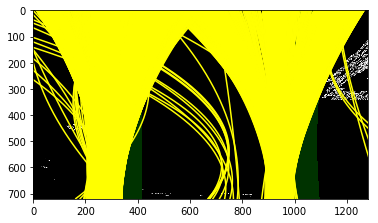

In [14]:
output = 'videos/result_1.mp4'
clip = VideoFileClip("videos/path_video_1.mp4")
video_clip = clip.fl_image(process_image) 
%time video_clip.write_videofile(output, audio=False)

In [15]:
from IPython.display import HTML

In [16]:
%%HTML
<tr>
<td><video width="320" height="240" controls>
  <source src="videos/path_video_1.mp4" type="video/mp4">
</video></td>

<td><video width="320" height="240" controls>
  <source src="videos/result_1.mp4" type="video/mp4">
</video></td>
</tr>


,
